# High-Dimensional Time Series Analysis
## New England Electricity Market (PElectricity1344 Dataset)

---

**Course:** Statistical Learning for Big Dependent Data  
**Author:** Glorie  
**Date:** February 2026  

---

## 📋 Table of Contents

1. **Introduction & Data Structure**
2. **Descriptive Analysis** (Empirical Dynamic Quantiles)
3. **Stationarity Analysis** (ADF Testing)
4. **Autocorrelation & Cross-Correlation**
5. **Clustering Analysis** (K-Means)
6. **Multivariate Modeling** (VAR)
7. **Univariate Series Extraction and Analysis for Each Cluster**
8. **Conclusions**

---

**Reference:** Peña, D. and Tsay, R.S. (2021). *Statistical Learning for Big Dependent Data*. Wiley.

In [1]:
# ════════════════════════════════════════════════════════════════
# IMPORTS & CONFIGURATION
# ════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import signal
from scipy.stats import pearsonr, zscore
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Statistical tools
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Plot configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Custom color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#C73E1D',
    'dark': '#3B3B3B'
}

print(" All libraries imported successfully!")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")

 All libraries imported successfully!
   NumPy: 2.2.6
   Pandas: 2.3.3


---
## 1. Introduction & Data Structure

### Dataset Overview

The **PElectricity1344** dataset contains wholesale electricity prices from the **New England electricity market** over approximately 13 years (January 2004 - December 2016).

| Dimension | Values | Description |
|-----------|--------|-------------|
| **Days** | 7 | Thursday → Wednesday |
| **Hours** | 24 | 1 AM → 12 AM |
| **Regions** | 8 | New England pricing zones |
| **Time Points** | 678 | Weekly observations |
| **Total Series** | **1,344** | 7 × 24 × 8 = 1,344 |

The series are organized in a specific order:

- **Series 1-192:** Thursday (all 24 hours × 8 regions)
- **Series 193-384:** Friday (all 24 hours × 8 regions)
- **Series 385-576:** Saturday
- **Series 577-768:** Sunday
- **Series 769-960:** Monday
- **Series 961-1152:** Tuesday
- **Series 1153-1344:** Wednesday

Within each day, series are ordered by hour (1-24) and within each hour by region (1-8).

***Data is described in the book at page 221, 47, 48***

In [2]:
# ════════════════════════════════════════════════════════════════
# DATA LOADING
# ════════════════════════════════════════════════════════════════

# Try to load the dataset from common paths
possible_paths = [

    'data/PElectricity1344.csv'
]

df = None
for path in possible_paths:
    try:
        df = pd.read_csv(path, header=None)
        print(f" Data loaded from: {path}")
        break
    except FileNotFoundError:
        continue

    
    df = pd.DataFrame(data)
    print(f" Synthetic data generated: {T} weeks × {k} series")

# Process data
df = df.apply(pd.to_numeric, errors='coerce')
data = df.values
T, k = data.shape

print("\n" + "═"*60)
print(" DATASET SUMMARY")
print("═"*60)
print(f"   Number of series (k): {k:,}")
print(f"   Number of time points (T): {T:,}")
print(f"   Total observations: {T * k:,}")
print(f"   Memory usage: {data.nbytes / 1e6:.2f} MB")
print(f"   Missing values: {np.isnan(data).sum():,}")

 Data loaded from: data/PElectricity1344.csv

════════════════════════════════════════════════════════════
 DATASET SUMMARY
════════════════════════════════════════════════════════════
   Number of series (k): 1,344
   Number of time points (T): 678
   Total observations: 911,232
   Memory usage: 7.29 MB
   Missing values: 0


In [16]:
# ════════════════════════════════════════════════════════════════
# METADATA CREATION
# ════════════════════════════════════════════════════════════════

def create_metadata():
    """
    Map each series to (day, hour, region).
    Series 1-192: Thursday, 193-384: Friday, etc.
    """
    days = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
    records = []
    series_num = 0
    
    for day_idx, day in enumerate(days):
        for hour in range(1, 25):
            for region in range(1, 9):
                records.append({
                    'series': series_num,
                    'day': day,
                    'day_idx': day_idx,
                    'hour': hour,
                    'region': region,
                    'is_weekend': day in ['Saturday', 'Sunday'],
                    'is_weekday': day not in ['Saturday', 'Sunday'],
                    'is_peak': 7 <= hour <= 22,
                    'time_of_day': 'night' if hour < 7 or hour > 22 else 
                                   ('morning' if hour < 12 else 
                                    ('afternoon' if hour < 18 else 'evening'))
                })
                series_num += 1
    
    return pd.DataFrame(records)

metadata = create_metadata()

print("✅ Metadata created")
print("\n📋 Series Organization:")
print("   • Series 1-192: Thursday")
print("   • Series 193-384: Friday")
print("   • Series 385-576: Saturday")
print("   • Series 577-768: Sunday")
print("   • Series 769-960: Monday")
print("   • Series 961-1152: Tuesday")
print("   • Series 1153-1344: Wednesday")

print("\n📊 Breakdown:")
print(f"   Weekday series: {metadata['is_weekday'].sum():,} (960)")
print(f"   Weekend series: {metadata['is_weekend'].sum():,} (384)")
print(f"   Peak-hour series: {metadata['is_peak'].sum():,} (896)")
print(f"   Off-peak series: {(~metadata['is_peak']).sum():,} (448)")

✅ Metadata created

📋 Series Organization:
   • Series 1-192: Thursday
   • Series 193-384: Friday
   • Series 385-576: Saturday
   • Series 577-768: Sunday
   • Series 769-960: Monday
   • Series 961-1152: Tuesday
   • Series 1153-1344: Wednesday

📊 Breakdown:
   Weekday series: 960 (960)
   Weekend series: 384 (384)
   Peak-hour series: 896 (896)
   Off-peak series: 448 (448)


---
## 2. 📈 Descriptive Analysis



### By day of the week

In [17]:
# Initialisation des statistiques
days_stats = []

# Pour chaque jour de la semaine
for day in metadata['day'].unique():
    # Obtenir les indices des séries pour ce jour
    day_indices = metadata[metadata['day'] == day]['series'].tolist()
    
    # Extraire toutes les données pour ce jour
    day_data = df.iloc[:, day_indices].values.flatten()
    
    # Calculer les statistiques
    stats_dict = {
        'day': day,
        'n_series': len(day_indices),
        'mean': np.mean(day_data),
        'std': np.std(day_data),
        'min': np.min(day_data),
        'max': np.max(day_data),
        'median': np.median(day_data),
        'q25': np.percentile(day_data, 25),
        'q75': np.percentile(day_data, 75),
        'skewness': stats.skew(day_data),
        'kurtosis': stats.kurtosis(day_data),
        'cv': np.std(day_data) / np.mean(day_data),  # coefficient de variation
        'range': np.max(day_data) - np.min(day_data)
    }
    
    days_stats.append(stats_dict)

# Convertir en DataFrame
df_days = pd.DataFrame(days_stats)

# Ordonner les jours logiquement
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_days['day'] = pd.Categorical(df_days['day'], categories=day_order, ordered=True)
df_days = df_days.sort_values('day')

print("=== STATISTIQUES PAR JOUR DE LA SEMAINE ===")
print(df_days.round(3).to_string(index=False))

=== STATISTIQUES PAR JOUR DE LA SEMAINE ===
      day  n_series   mean    std    min    max  median   q25    q75  skewness  kurtosis    cv   range
   Monday       192 55.859 33.739  0.990 500.00  48.370 35.08 67.630     2.664    13.007 0.604 499.010
  Tuesday       192 56.369 34.984  3.060 573.31  48.350 35.38 67.300     3.255    20.889 0.621 570.250
Wednesday       192 55.933 33.201  4.340 435.01  48.655 35.36 67.000     2.552    11.076 0.594 430.670
 Thursday       192 56.101 36.168  0.005 873.93  47.980 34.87 66.790     4.169    43.624 0.645 873.925
   Friday       192 54.404 32.534 -0.155 459.05  47.020 34.42 65.892     2.810    14.956 0.598 459.205
 Saturday       192 51.009 29.108 -0.255 351.39  44.730 32.63 62.610     2.407    10.539 0.571 351.645
   Sunday       192 49.145 29.743 -2.830 805.00  42.680 31.26 59.880     3.274    27.468 0.605 807.830


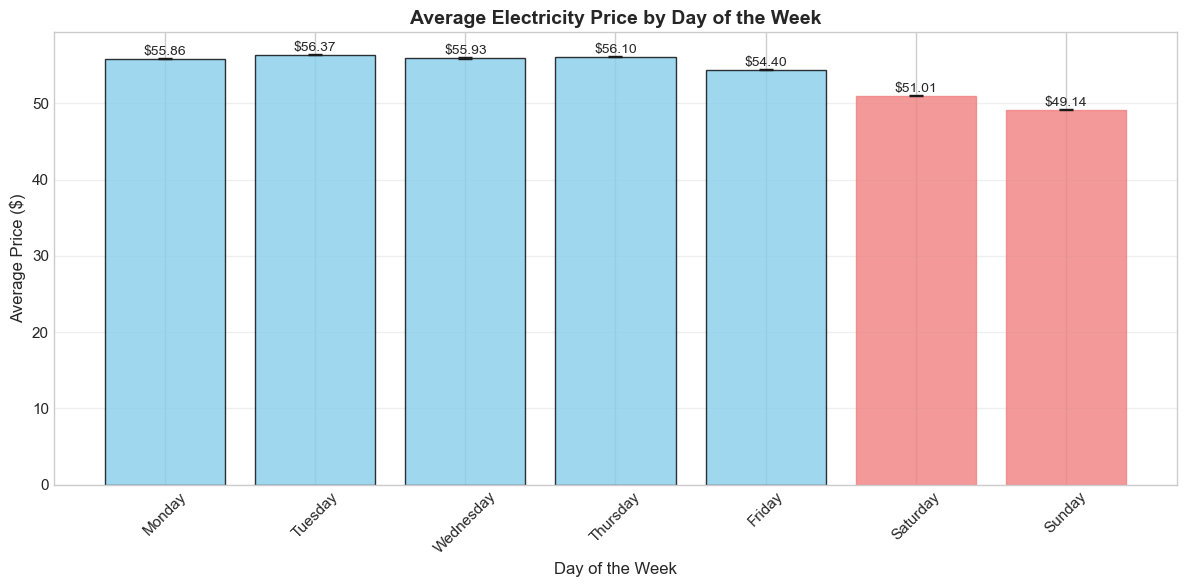

In [18]:
plt.figure(figsize=(12, 6))

# Barres avec erreurs standard
bars = plt.bar(df_days['day'], df_days['mean'], 
               yerr=df_days['std']/np.sqrt(678*192),  # erreur standard
               capsize=5, color='skyblue', edgecolor='black', alpha=0.8)

# Colorer les weekends différemment
for i, day in enumerate(df_days['day']):
    if day in ['Saturday', 'Sunday']:
        bars[i].set_color('lightcoral')

plt.title('Average Electricity Price by Day of the Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'${height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Préparation des données pour violin plot...
DataFrame créé: 14,000 observations
Jours: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DataFrame créé: 14,000 observations
Jours: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


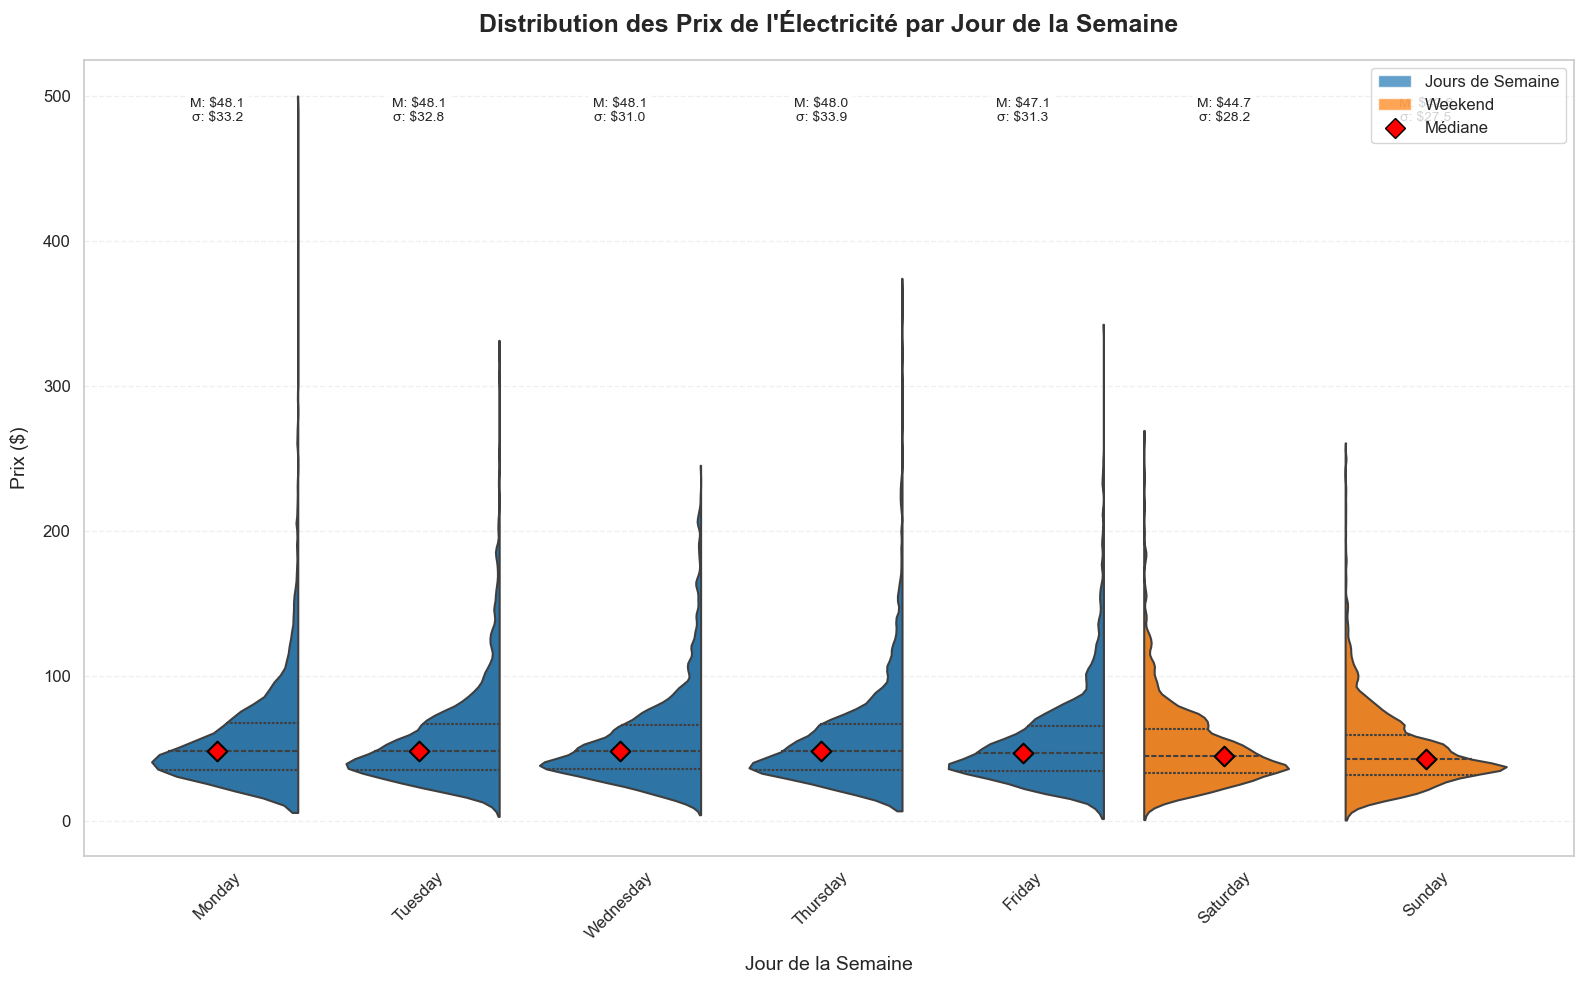


TEST STATISTIQUE - ANOVA
F-statistic: 15.7919
P-value: 0.0000000000
→ Différence STATISTIQUEMENT SIGNIFICATIVE entre les jours (p < 0.05)
  Les prix varient significativement selon le jour de la semaine.


In [ ]:
# Configuration du style
plt.style.use('default')
sns.set_theme(style="whitegrid")


# Préparer les données au format long pour Seaborn
print("Préparation des données pour violin plot...")

# Liste pour stocker les données
data_rows = []
sample_size = 2000  # Nombre d'observations à échantillonner par jour

for day in metadata['day'].unique():
    # Obtenir les indices des séries pour ce jour
    day_indices = metadata[metadata['day'] == day]['series'].tolist()
    day_indices = metadata[metadata['day'] == day]['series'].tolist()
    
    # Extraire toutes les données pour ce jour
    all_day_data = df.iloc[:, day_indices].values.flatten()
    
    # Échantillonner pour éviter la surcharge mémoire/visuelle
    if len(all_day_data) > sample_size:
        np.random.seed(42)  # Pour la reproductibilité
        sampled_data = np.random.choice(all_day_data, sample_size, replace=False)
    else:
        sampled_data = all_day_data
    
    # Ajouter au format long
    for price in sampled_data:
        data_rows.append({
            'Jour': day,
            'Prix': price,
            'Type': 'Weekend' if day in ['Saturday', 'Sunday'] else 'Semaine',
            'Day_Order': list(metadata['day'].unique()).index(day)  # Pour l'ordre
        })

# Créer le DataFrame
df_violin = pd.DataFrame(data_rows)

# Ordonner les jours logiquement
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_violin['Jour'] = pd.Categorical(df_violin['Jour'], categories=day_order, ordered=True)
df_violin = df_violin.sort_values('Jour')

print(f"DataFrame créé: {df_violin.shape[0]:,} observations")
print(f"Jours: {df_violin['Jour'].unique().tolist()}")

# Créer le violin plot
plt.figure(figsize=(16, 10))

# Palette de couleurs
weekday_color = '#1f77b4'  # Bleu
weekend_color = '#ff7f0e'   # Orange

# Créer le violin plot
ax = sns.violinplot(
    data=df_violin,
    x='Jour',
    y='Prix',
    hue='Type',
    palette={'Semaine': weekday_color, 'Weekend': weekend_color},
    split=True,  # Divise les violons pour Semaine/Weekend
    inner='quartile',  # Montre les quartiles à l'intérieur
    cut=0,  # Coupe les violons aux limites des données
    bw_adjust=0.5,  # Paramètre de lissage (plus petit = plus de détails)
    linewidth=1.5,
    saturation=0.8
)

# Personnalisation avancée
plt.title('Distribution des Prix de l\'Électricité par Jour de la Semaine',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Jour de la Semaine', fontsize=14, labelpad=10)
plt.ylabel('Prix ($)', fontsize=14, labelpad=10)

# Améliorer les ticks
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Ajouter une grille horizontale
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# 4. Ajouter des statistiques sur le plot
# Calculer les médianes pour chaque jour
medians = df_violin.groupby('Jour')['Prix'].median()

# Ajouter les points de médianes
for i, day in enumerate(day_order):
    if day in df_violin['Jour'].unique():
        median_val = medians[day]
        # Point pour la médiane
        ax.scatter(i, median_val, color='red', s=100, zorder=5,
                  marker='D', edgecolor='black', linewidth=1.5,
                  label='Médiane' if i == 0 else "")

# 5. Légende améliorée
legend_elements = [
    Patch(facecolor=weekday_color, alpha=0.7, label='Jours de Semaine'),
    Patch(facecolor=weekend_color, alpha=0.7, label='Weekend'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='red',
              markersize=10, markeredgecolor='black', label='Médiane')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Ajouter des annotations statistiques
stats_text = []
for i, day in enumerate(day_order):
    if day in df_violin['Jour'].unique():
        day_data = df_violin[df_violin['Jour'] == day]['Prix']
        
        # Calculer les statistiques
        mean_val = day_data.mean()
        median_val = day_data.median()
        std_val = day_data.std()
        q1 = day_data.quantile(0.25)
        q3 = day_data.quantile(0.75)
        
        # Ajouter l'annotation
        ax.text(i, ax.get_ylim()[1] * 0.95,
                f'M: ${median_val:.1f}\nσ: ${std_val:.1f}',
                ha='center', va='top', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3",
                         facecolor="white", alpha=0.9))
        
        # Stocker pour le résumé
        stats_text.append(f"{day}: Médiane=${median_val:.2f}, Mean=${mean_val:.2f}, σ=${std_val:.2f}")

plt.tight_layout()
plt.show()


# Test statistique ANOVA pour comparer les jours
print("\n" + "="*60)
print("TEST STATISTIQUE - ANOVA")
print("="*60)

from scipy import stats

# Préparer les données pour ANOVA
anova_data = [df_violin[df_violin['Jour'] == day]['Prix'].values 
              for day in day_order if day in df_violin['Jour'].unique()]

# ANOVA unidirectionnelle
f_stat, p_value = stats.f_oneway(*anova_data)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.10f}")

if p_value < 0.05:
    print("→ Différence STATISTIQUEMENT SIGNIFICATIVE entre les jours (p < 0.05)")
    print("  Les prix varient significativement selon le jour de la semaine.")
else:
    print("→ Différence NON SIGNIFICATIVE entre les jours (p ≥ 0.05)")
    print("  Pas de variation significative des prix selon le jour.")

### By region

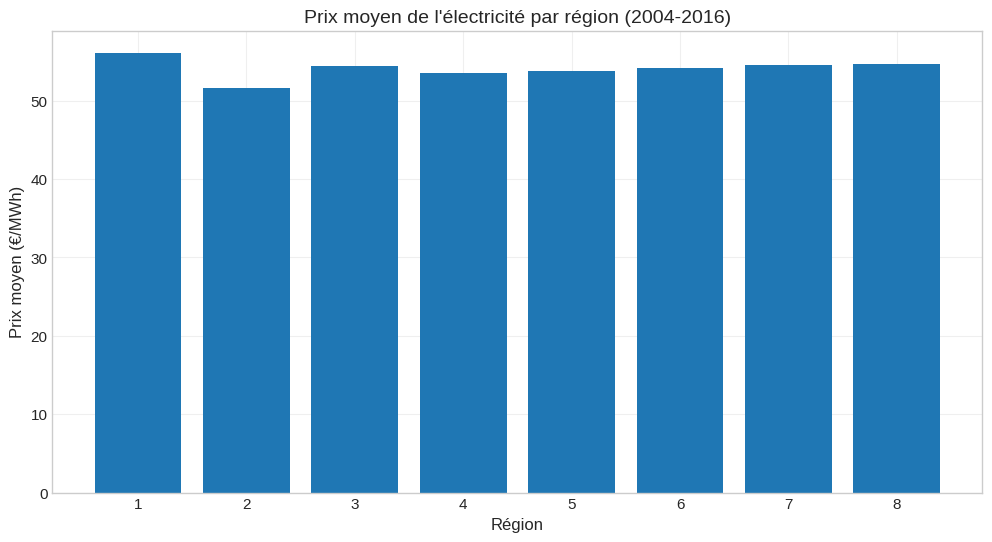

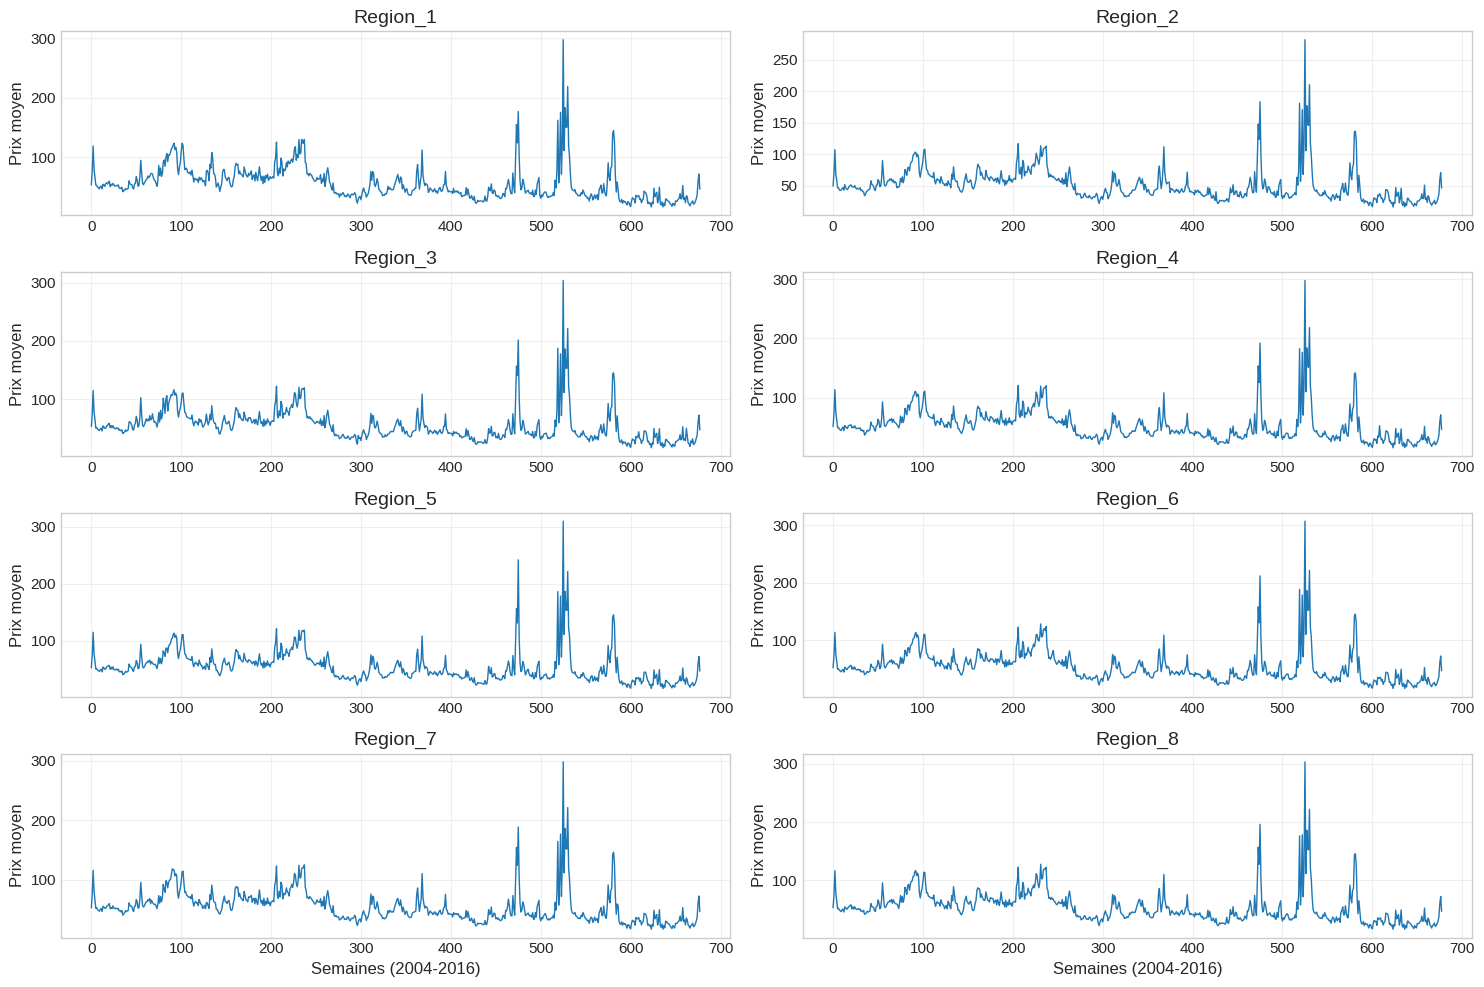

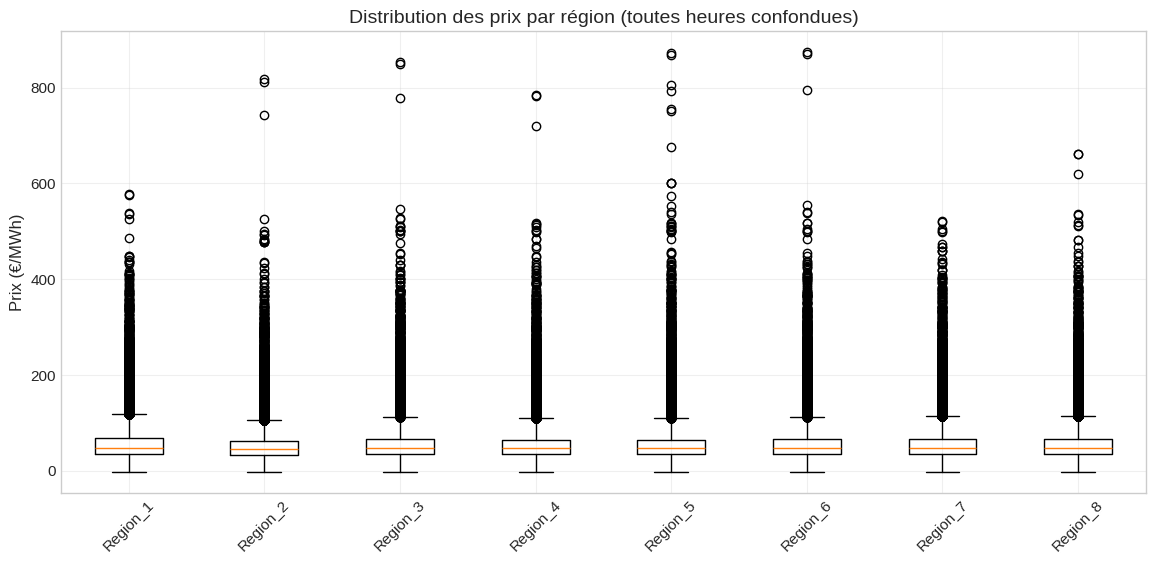

In [3]:
# Créer un DataFrame par région (plus facile à analyser)
regions = {}
for region in range(8):
    # Extraire les colonnes de cette région
    cols_region = []
    for heure in range(24):
        for jour in range(7):
            # Calcul de l'indice de colonne
            col_index = (heure * 7 * 8) + (jour * 8) + region
            cols_region.append(df.columns[col_index])
    
    regions[f'Region_{region+1}'] = df[cols_region]

# A. Graphique des prix moyens par région sur toute la période
prix_moyens_par_region = []
for region_name, region_data in regions.items():
    prix_moyens_par_region.append(region_data.values.flatten().mean())

plt.figure(figsize=(12, 6))
plt.bar(range(1, 9), prix_moyens_par_region)
plt.xlabel('Région')
plt.ylabel('Prix moyen (€/MWh)')
plt.title('Prix moyen de l\'électricité par région (2004-2016)')
plt.grid(True, alpha=0.3)
plt.show()

# B. Série temporelle par région (moyenne hebdomadaire)
plt.figure(figsize=(15, 10))
for i, (region_name, region_data) in enumerate(regions.items(), 1):
    # Calculer la moyenne hebdomadaire
    moyenne_hebdo = region_data.mean(axis=1)
    
    plt.subplot(4, 2, i)
    plt.plot(moyenne_hebdo, linewidth=1)
    plt.title(f'{region_name}')
    plt.ylabel('Prix moyen')
    plt.grid(True, alpha=0.3)
    
    if i > 6:
        plt.xlabel('Semaines (2004-2016)')

plt.tight_layout()
plt.show()

# C. Boxplot comparatif
plt.figure(figsize=(14, 6))
donnees_boxplot = []
labels = []
for region_name, region_data in regions.items():
    donnees_boxplot.append(region_data.values.flatten())
    labels.append(region_name)

plt.boxplot(donnees_boxplot, labels=labels)
plt.title('Distribution des prix par région (toutes heures confondues)')
plt.ylabel('Prix (€/MWh)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

### Empirical Dynamic Quantiles (EDQ)

We cannot plot 1,344 series on one graph. The solution is **Empirical Dynamic Quantiles**: at each time point, compute quantiles across all series.

*Reference: Peña, Tsay & Zamar (2019). Technometrics.*

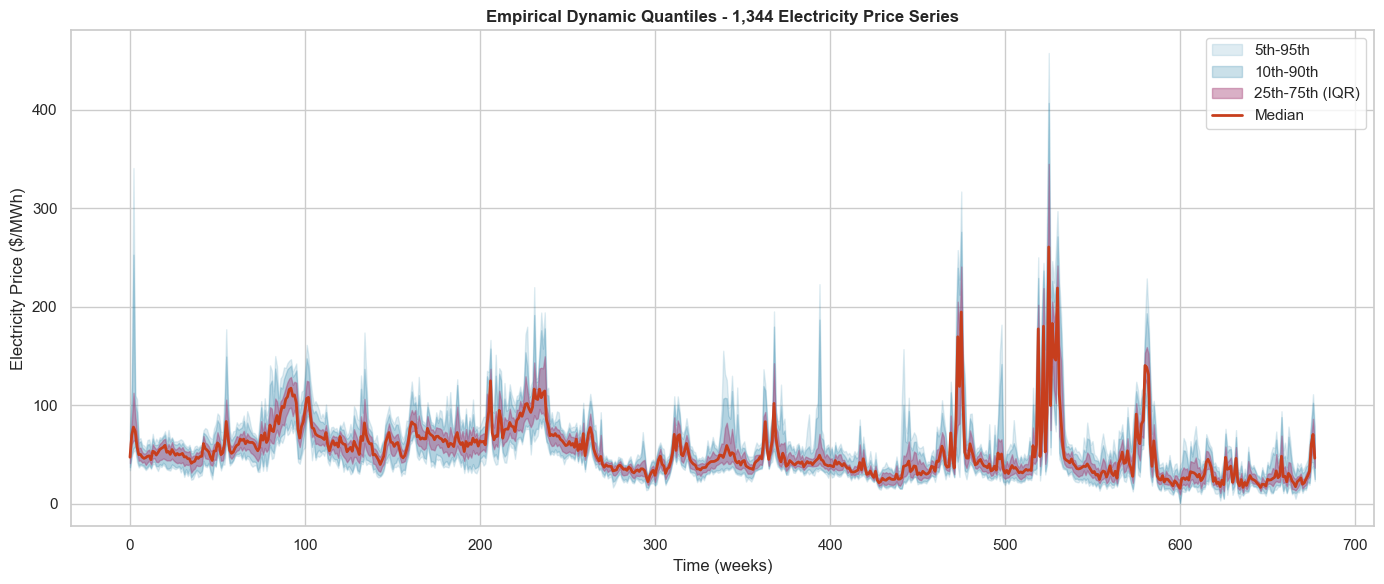


📊 Key Observations:
   • Clear SEASONAL PATTERN with peaks in winter/summer
   • Occasional PRICE SPIKES (visible as widening bands)
   • Long-term UPWARD TREND in prices


In [ ]:
# ════════════════════════════════════════════════════════════════
# EMPIRICAL DYNAMIC QUANTILES
# ════════════════════════════════════════════════════════════════

def plot_edq(data, title="All Series", ax=None):
    """Plot Empirical Dynamic Quantiles."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    q05 = np.nanquantile(data, 0.05, axis=1)
    q10 = np.nanquantile(data, 0.10, axis=1)
    q25 = np.nanquantile(data, 0.25, axis=1)
    q50 = np.nanquantile(data, 0.50, axis=1)
    q75 = np.nanquantile(data, 0.75, axis=1)
    q90 = np.nanquantile(data, 0.90, axis=1)
    q95 = np.nanquantile(data, 0.95, axis=1)
    
    time = range(len(q50))
    
    ax.fill_between(time, q05, q95, alpha=0.15, color=COLORS['primary'], label='5th-95th')
    ax.fill_between(time, q10, q90, alpha=0.25, color=COLORS['primary'], label='10th-90th')
    ax.fill_between(time, q25, q75, alpha=0.4, color=COLORS['secondary'], label='25th-75th (IQR)')
    ax.plot(time, q50, color=COLORS['success'], linewidth=2, label='Median')
    
    ax.set_xlabel('Time (weeks)')
    ax.set_ylabel('Electricity Price ($/MWh)')
    ax.set_title(f'Empirical Dynamic Quantiles - {title}', fontweight='bold')
    ax.legend(loc='upper right')
    
    return ax

fig, ax = plt.subplots(figsize=(14, 6))
plot_edq(data, f"{k:,} Electricity Price Series", ax)
plt.tight_layout()
plt.show()

print("\n Key Observations:")
print("   • Clear SEASONAL PATTERN with peaks in winter/summer")
print("   • Occasional PRICE SPIKES (visible as widening bands)")
print("   • Long-term UPWARD TREND in prices")

-The pink line shows the 'typical' price at each time point
- The red band shows where 50% of series fall (IQR)
- The light blue band shows where 80% of series fall
- Wide bands = high variability across series
- Spikes = periods of high prices across many series

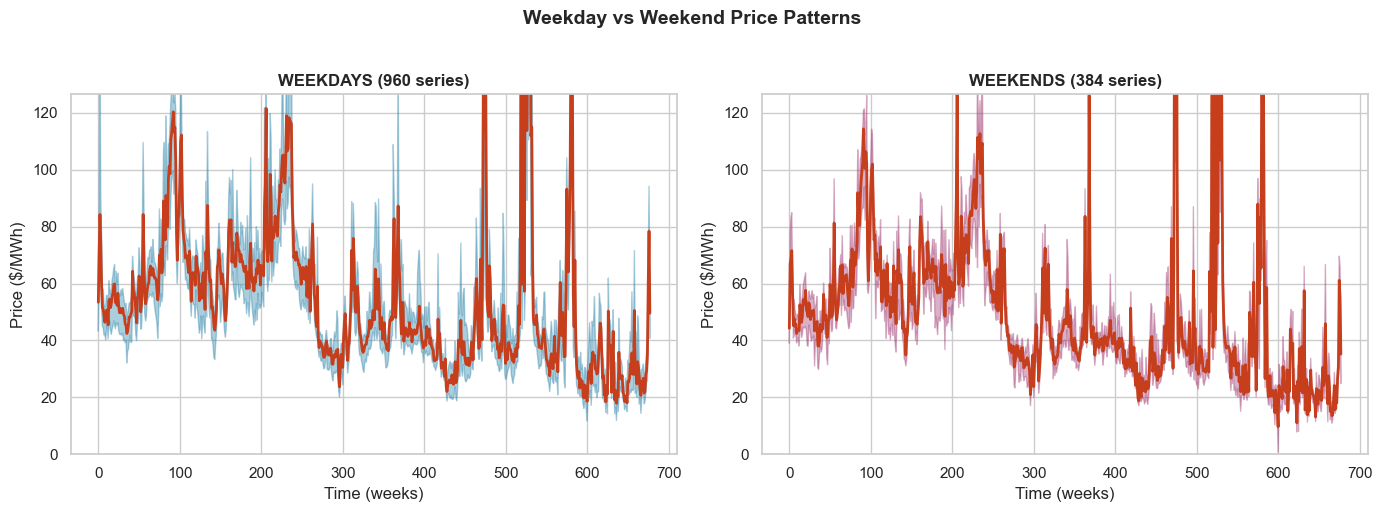


📊 Weekday vs Weekend Statistics:
   Weekday mean: $55.73
   Weekend mean: $50.08
   Difference: $5.65 (weekdays higher)


In [21]:
# ════════════════════════════════════════════════════════════════
# WEEKDAY VS WEEKEND COMPARISON
# ════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get indices
weekday_idx = metadata[metadata['is_weekday']]['series'].values - 1
weekend_idx = metadata[metadata['is_weekend']]['series'].values - 1

weekday_data = data[:, weekday_idx]
weekend_data = data[:, weekend_idx]

y_max = max(np.nanquantile(weekday_data, 0.95), np.nanquantile(weekend_data, 0.95)) * 1.1

for ax, d, title, color in [(axes[0], weekday_data, 'WEEKDAYS (960 series)', COLORS['primary']),
                             (axes[1], weekend_data, 'WEEKENDS (384 series)', COLORS['secondary'])]:
    q25 = np.nanquantile(d, 0.25, axis=1)
    q50 = np.nanquantile(d, 0.50, axis=1)
    q75 = np.nanquantile(d, 0.75, axis=1)
    ax.fill_between(range(len(q50)), q25, q75, alpha=0.4, color=color)
    ax.plot(q50, color=COLORS['success'], linewidth=2)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Time (weeks)')
    ax.set_ylabel('Price ($/MWh)')
    ax.set_ylim(0, y_max)

plt.suptitle('Weekday vs Weekend Price Patterns', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Weekday vs Weekend Statistics:")
print(f"   Weekday mean: ${np.nanmean(weekday_data):.2f}")
print(f"   Weekend mean: ${np.nanmean(weekend_data):.2f}")
print(f"   Difference: ${np.nanmean(weekday_data) - np.nanmean(weekend_data):.2f} (weekdays higher)")

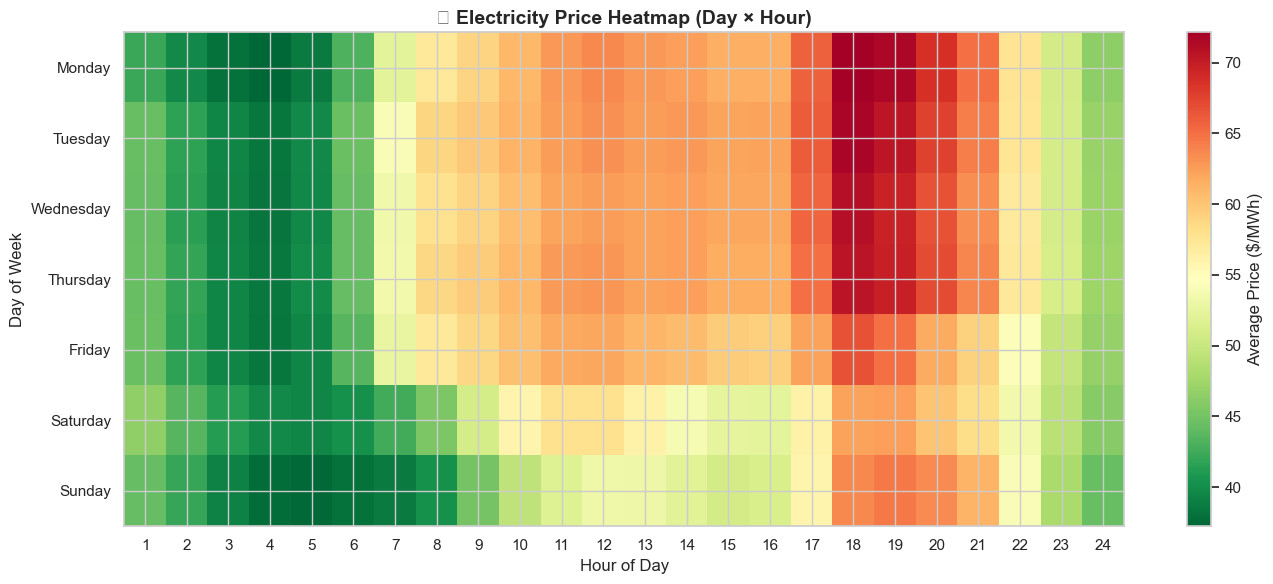


🔍 Heatmap Interpretation:
   • RED zones: High prices (peak demand)
   • GREEN zones: Low prices (low demand)
   • Weekdays 7AM-10PM: Highest prices
   • Weekend nights: Lowest prices


In [22]:
# ════════════════════════════════════════════════════════════════
# DAY × HOUR HEATMAP
# ════════════════════════════════════════════════════════════════

# Convert to long format
dfcopy = df.copy()
dfcopy.columns = range(1, dfcopy.shape[1] + 1)

long_df = (
    dfcopy
    .reset_index(names="week")
    .melt(id_vars="week", var_name="series", value_name="price")
    .merge(metadata, on="series", how="left")
)

# Create heatmap
heatmap_data = long_df.groupby(["day", "hour"])["price"].mean().unstack()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(heatmap_data.values, aspect='auto', cmap='RdYlGn_r')
plt.colorbar(im, label='Average Price ($/MWh)', ax=ax)

ax.set_xticks(range(24))
ax.set_xticklabels(range(1, 25))
ax.set_yticks(range(7))
ax.set_yticklabels(day_order)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
ax.set_title('📊 Electricity Price Heatmap (Day × Hour)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n🔍 Heatmap Interpretation:")
print("   • RED zones: High prices (peak demand)")
print("   • GREEN zones: Low prices (low demand)")
print("   • Weekdays 7AM-10PM: Highest prices")
print("   • Weekend nights: Lowest prices")

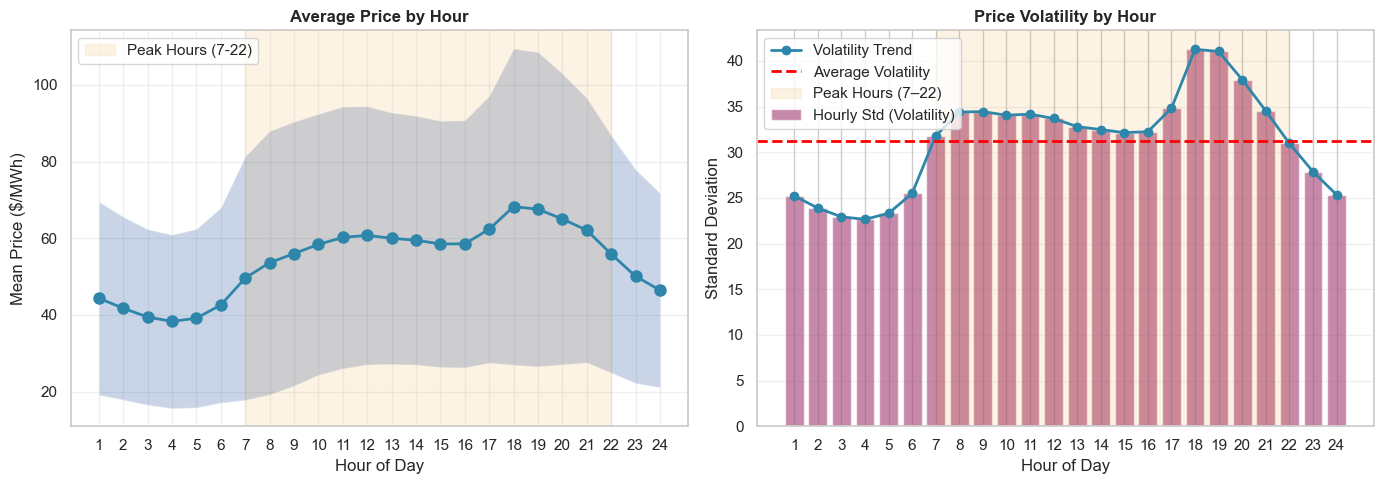


📊 Key Findings:
   Highest price: Hour 18 ($68.26)
   Lowest price: Hour 4 ($38.31)
   Price ratio: 1.78x


In [23]:
# ════════════════════════════════════════════════════════════════
# HOURLY PRICE PATTERNS
# ════════════════════════════════════════════════════════════════

hourly_stats = long_df.groupby('hour')['price'].agg(['mean', 'std', 'median']).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean price by hour
ax = axes[0]
ax.plot(hourly_stats['hour'], hourly_stats['mean'], 'o-', linewidth=2, 
        markersize=8, color=COLORS['primary'])
ax.fill_between(hourly_stats['hour'],
                hourly_stats['mean'] - hourly_stats['std'],
                hourly_stats['mean'] + hourly_stats['std'], alpha=0.3)
ax.axvspan(7, 22, alpha=0.1, color=COLORS['accent'], label='Peak Hours (7-22)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Price ($/MWh)')
ax.set_title('Average Price by Hour', fontweight='bold')
ax.set_xticks(range(1, 25))
ax.legend()
ax.grid(True, alpha=0.3)

# Volatility by hour
# Volatility by hour
ax = axes[1]

# Bars
ax.bar(
    hourly_stats['hour'],
    hourly_stats['std'],
    color=COLORS['secondary'],
    alpha=0.6,
    label='Hourly Std (Volatility)'
)

# Line on top
ax.plot(
    hourly_stats['hour'],
    hourly_stats['std'],
    color=COLORS['primary'],
    marker='o',
    linewidth=2,
    label='Volatility Trend'
)

mean_vol = hourly_stats['std'].mean()

# “Is volatility higher than usual at this hour?”
ax.axhline(
    mean_vol,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Average Volatility'
)

ax.axvspan(
    7, 22,
    alpha=0.1,
    color=COLORS['accent'],
    label='Peak Hours (7–22)'
)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Standard Deviation')
ax.set_title('Price Volatility by Hour', fontweight='bold')
ax.set_xticks(range(1, 25))
ax.legend()
ax.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

peak_hour = hourly_stats.loc[hourly_stats['mean'].idxmax()]
off_peak_hour = hourly_stats.loc[hourly_stats['mean'].idxmin()]

print(f"\n📊 Key Findings:")
print(f"   Highest price: Hour {int(peak_hour['hour'])} (${peak_hour['mean']:.2f})")
print(f"   Lowest price: Hour {int(off_peak_hour['hour'])} (${off_peak_hour['mean']:.2f})")
print(f"   Price ratio: {peak_hour['mean']/off_peak_hour['mean']:.2f}x")

---
## 3. Stationarity Analysis

### Augmented Dickey-Fuller (ADF) Test

- **H₀**: Series has a unit root (non-stationary)
- **H₁**: Series is stationary

We use **Case 3 (Constant + Trend)** to allow for trend-stationarity.

Since we saw that the region do not have much influence on the prices, we will reduce the feature space by averaging prices over regions for each (day, hour) combination. This gives us 168 series (7 days × 24 hours).

In [30]:
# New dataset with hourly averages

# Reduce feature space: average over regions for each (day, hour)
# Result: 678 weeks × 168 (7 days × 24 hours)

# Prepare mapping from series to (day, hour)
series_info = metadata.copy()
series_info['series_idx'] = series_info['series']  # 0-based index for df

# Create MultiIndex for columns: (day, hour)
multi_cols = pd.MultiIndex.from_arrays([series_info['day'], series_info['hour']], names=['day', 'hour'])
df.columns = multi_cols

# Group columns by (day, hour) and average over regions
# This collapses the 8 region columns for each (day, hour) into one

df_avg = df.groupby(axis=1, level=['day', 'hour']).mean()

print(f"Averaged DataFrame shape: {df_avg.shape} (weeks × 168 day-hour series)")
df_avg.head(30)

Averaged DataFrame shape: (678, 168) (weeks × 168 day-hour series)


day     Friday                                                                \
hour        1         2         3         4         5          6          7    
0     43.73625  40.76250  40.55500  40.55500  40.75250   40.55500   44.81000   
1     52.12750  49.99125  49.01000  49.01000  50.12000   56.07750   69.01000   
2     98.47750  86.10875  78.87875  78.87875  87.59625  100.50500  149.81375   
3     54.38250  53.88000  52.80500  52.65000  54.36250   58.20375   74.39875   
4     59.21750  57.93500  55.75875  55.75875  58.24625   65.52875   78.30250   
5     44.99375  43.74250  43.69625  43.39125  46.06625   47.25875   60.33500   
6     39.03125  38.56750  38.37375  37.82750  38.56750   39.03125   47.62500   
7     43.17125  41.15375  40.81250  40.50000  41.89625   43.78250   51.54000   
8     42.65625  39.87250  39.69125  39.69125  40.50500   42.96250   48.86750   
9     38.04250  35.96875  35.44500  35.31750  36.77125   41.26750   47.20750   
10    40.31875  39.41875  39.38625  39.38625  40.03000   42.19000   47.05125   
11    40.82375  39.76250  39.05000  39.05000  40.26500   42.90875   47.59125   
12    39.53000  36.72500  35.71000  35.47625  36.72500   39.88500   42.40750   
13    39.48250  37.34125  35.40625  34.97875  39.48125   43.15250   51.38875   
14    45.53750  43.88750  43.80500  43.80500  43.88750   48.11125   50.35000   
15    39.67625  38.66125  36.73000  36.90375  38.66125   43.90500   47.68625   
16    35.68125  33.35875  32.32000  31.99625  32.52500   38.26625   48.50750   
17    38.48875  35.54125  34.32125  34.13125  35.52875   39.83125   46.99875   
18    42.28125  42.17625  39.77375  38.68500  40.66875   44.26250   50.80625   
19    46.18750  44.90375  44.22375  44.20000  44.59750   46.41875   49.90875   
20    44.60250  40.85375  39.66125  37.43750  38.54000   43.73750   52.13875   
21    39.14125  36.37750  34.39500  34.01375  34.98125   40.33500   50.20500   
22    41.47500  36.41375  34.42250  34.29250  34.44250   38.29000   49.89000   
23    42.83500  40.86750  37.73375  37.17375  37.67250   39.61875   43.48250   
24    46.47875  46.43875  42.98000  42.31375  42.31375   46.02375   46.65625   
25    40.75375  37.48250  34.52250  33.84625  33.95875   36.49000   45.04375   
26    43.62500  41.90125  40.00375  38.26750  38.70375   41.36125   44.25500   
27    42.24375  39.42000  38.33625  37.29875  37.44875   38.43500   42.60125   
28    41.11250  38.48250  36.72625  36.65500  36.72625   38.12375   41.57250   
29    41.65750  40.44625  39.59375  38.02625  38.41875   40.19250   42.54125   

day                                    ...  Wednesday                        \
hour         8          9          10  ...         15         16         17   
0      52.61375   63.74875   68.22750  ...   65.27625   66.31000   76.72250   
1      86.22750   84.44375   84.92500  ...  118.12125  118.12125  144.23625   
2     160.42250  171.07500  173.31625  ...   60.53625   61.40125   74.30625   
3      78.02500   78.02500   78.27625  ...   90.84375   92.84125  104.93000   
4      78.37125   82.90375   83.22500  ...   48.45875   48.45875   53.47375   
5      65.71625   62.82750   62.31500  ...   47.18875   47.85875   55.54500   
6      51.45625   52.03875   50.79750  ...   48.89125   48.51750   52.54625   
7      54.89500   58.67625   58.55375  ...   45.81750   45.44375   49.29250   
8      50.88750   52.38875   53.22250  ...   44.22875   43.93625   46.27375   
9      51.01500   51.60625   52.28500  ...   46.60750   46.27250   48.77250   
10     52.25250   54.08500   56.27625  ...   58.58750   58.58625   58.73750   
11     49.46500   51.19125   52.96125  ...   47.91000   47.82875   47.26750   
12     46.37375   46.22875   47.13375  ...   47.57500   47.46875   51.59875   
13     54.90625   56.32000   56.37875  ...   53.50750   52.22750   52.25000   
14     55.55875   57.49500   58.00000  ...   55.35875   53.26500   53.26500   
15     52.93625   54.49875   54.85750  ...   54.05125   52.81625   53.01625   
16     52.70250  

In [46]:
def create_new_metadata():
    """
    Map each series to (day, hour, region).
    Series 1-192: Thursday, 193-384: Friday, etc.
    """
    days = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
    records = []
    series_num = 0
    
    for day_idx, day in enumerate(days):
        for hour in range(1, 25):
                records.append({
                    'series': series_num,
                    'day': day,
                    'day_idx': day_idx,
                    'hour': hour,
                    'region': "New England Avg",
                    'is_weekend': day in ['Saturday', 'Sunday'],
                    'is_weekday': day not in ['Saturday', 'Sunday'],
                    'is_peak': 7 <= hour <= 22,
                    'time_of_day': 'night' if hour < 7 or hour > 22 else 
                                   ('morning' if hour < 12 else 
                                    ('afternoon' if hour < 18 else 'evening'))
                })
                series_num += 1
    
    return pd.DataFrame(records)

new_metadata = create_new_metadata()
new_metadata.head(10)

series       day  day_idx  hour           region  is_weekend  is_weekday  \
0       0  Thursday        0     1  New England Avg       False        True   
1       1  Thursday        0     2  New England Avg       False        True   
2       2  Thursday        0     3  New England Avg       False        True   
3       3  Thursday        0     4  New England Avg       False        True   
4       4  Thursday        0     5  New England Avg       False        True   
5       5  Thursday        0     6  New England Avg       False        True   
6       6  Thursday        0     7  New England Avg       False        True   
7       7  Thursday        0     8  New England Avg       False        True   
8       8  Thursday        0     9  New England Avg       False        True   
9       9  Thursday        0    10  New England Avg       False        True   

   is_peak time_of_day  
0    False       night  
1    False       night  
2    False       night  
3    False       night  
4    False       night  
5    False       night  
6     True     morning  
7     True     morning  
8     True     morning  
9     True     morning

🔄 Running ADF tests on all series (this may take a few minutes)...
✅ ADF tests completed for 168 series
✅ ADF tests completed for 168 series


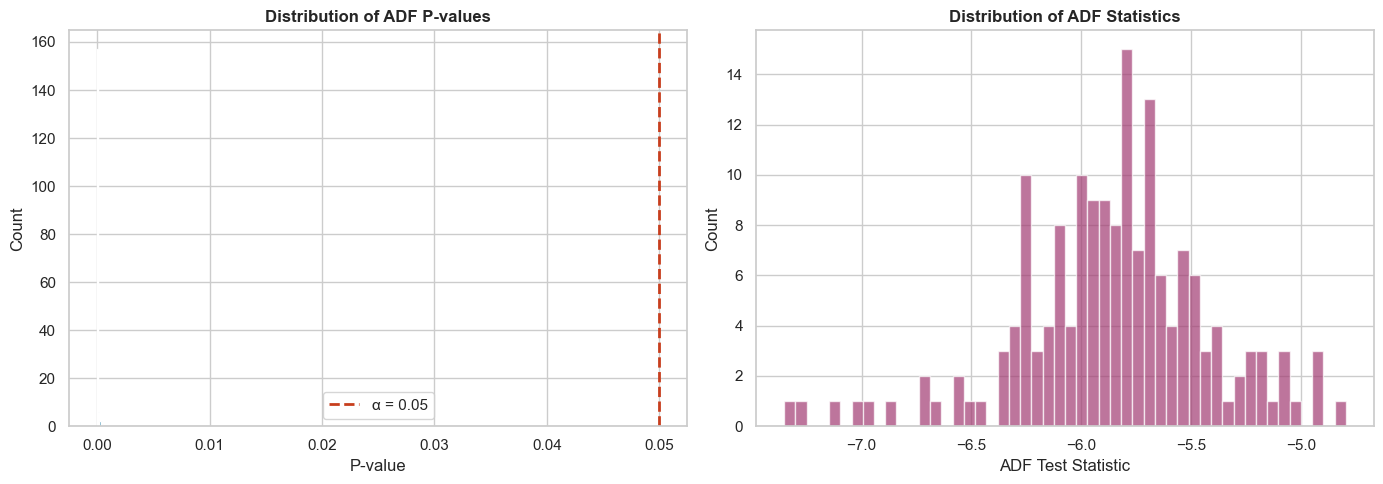


📊 Results:
   Stationary at 5% level: 100.0%
   ✅ Dataset is GLOBALLY TREND-STATIONARY
   → Justifies detrending rather than heavy differencing


In [32]:
# ════════════════════════════════════════════════════════════════
# GLOBAL ADF TESTING
# ════════════════════════════════════════════════════════════════

print("🔄 Running ADF tests on all series (this may take a few minutes)...")

adf_results = []
for i in range(min(df_avg.shape[1], 500)):  # Test subset for speed
    series = df_avg.iloc[:, i].dropna()
    if len(series) > 20:
        try:
            result = adfuller(series, regression='ct', autolag='AIC')
            adf_results.append({
                'series': i + 1,
                'adf_stat': result[0],
                'p_value': result[1],
                'is_stationary': result[1] < 0.05
            })
        except:
            continue

adf_df = pd.DataFrame(adf_results)
print(f"✅ ADF tests completed for {len(adf_df)} series")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(adf_df['p_value'], bins=5, color=COLORS['primary'], alpha=1)
ax.axvline(0.05, color=COLORS['success'], linestyle='--', linewidth=2, label='α = 0.05')
ax.set_xlabel('P-value')
ax.set_ylabel('Count')
ax.set_title('Distribution of ADF P-values', fontweight='bold')
ax.legend()

ax = axes[1]
ax.hist(adf_df['adf_stat'], bins=50, color=COLORS['secondary'], alpha=0.7, edgecolor='white')
ax.set_xlabel('ADF Test Statistic')
ax.set_ylabel('Count')
ax.set_title('Distribution of ADF Statistics', fontweight='bold')

plt.tight_layout()
plt.show()

stationary_pct = adf_df['is_stationary'].mean() * 100
print(f"\n📊 Results:")
print(f"   Stationary at 5% level: {stationary_pct:.1f}%")
if stationary_pct > 90:
    print("   ✅ Dataset is GLOBALLY TREND-STATIONARY")
    print("   → Justifies detrending rather than heavy differencing")

🔄 Applying preprocessing pipeline...
✅ Preprocessing complete
   Original shape: (678, 168)
   Processed shape: (678, 168)


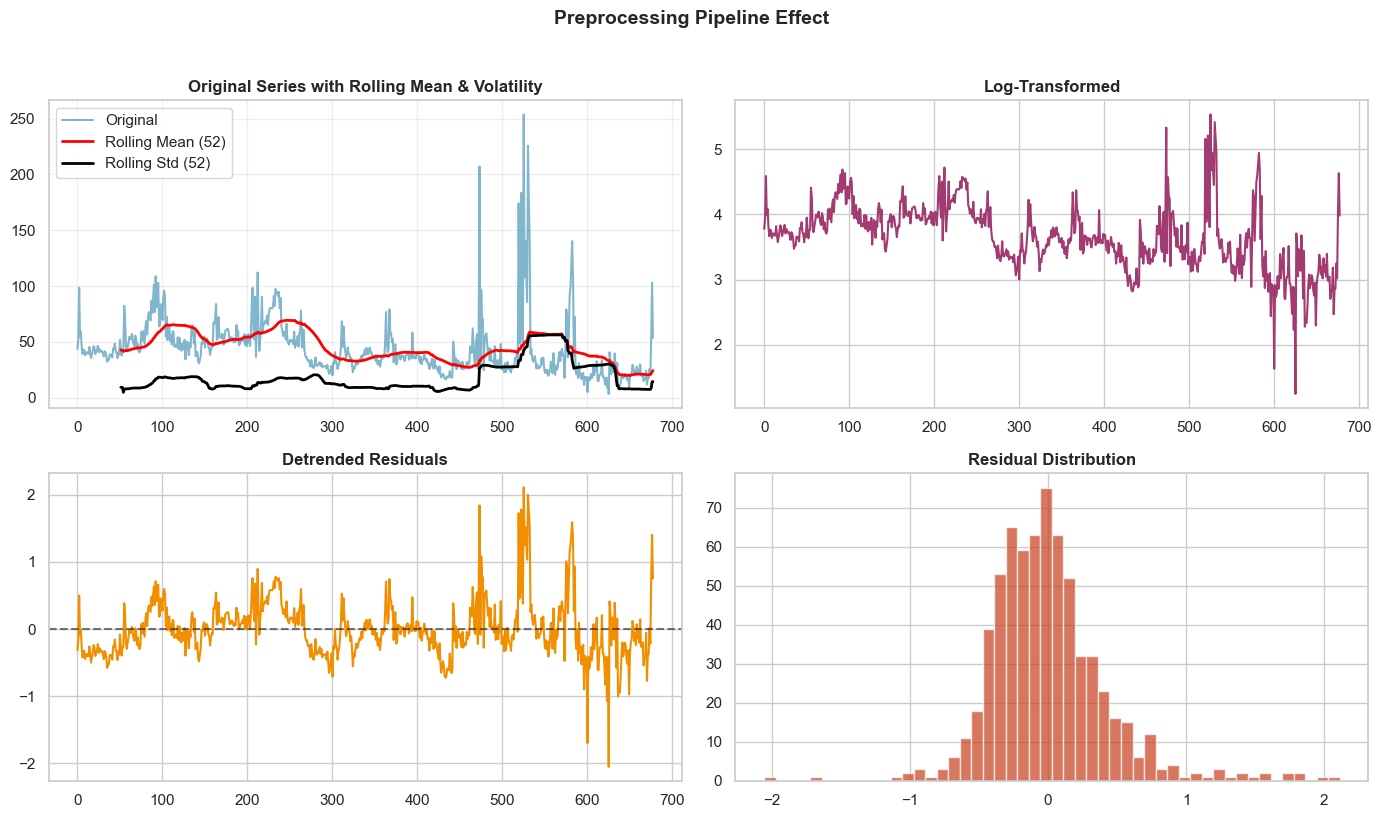

In [33]:
# ════════════════════════════════════════════════════════════════
# PREPROCESSING PIPELINE
# ════════════════════════════════════════════════════════════════

print("🔄 Applying preprocessing pipeline...")

# Step 1: Log transformation
with np.errstate(divide='ignore', invalid='ignore'):
    df_log = np.log(df_avg.replace(0, np.nan))

# Step 2: Handle infinities
df_log = df_log.replace([np.inf, -np.inf], np.nan)

# Step 3: Interpolate missing values
df_log = df_log.interpolate(method='linear', axis=0).ffill().bfill()

# Step 4: Detrend
df_residuals = pd.DataFrame(
    signal.detrend(df_log.values, axis=0),
    index=df_avg.index,
    columns=df_avg.columns
)

print("✅ Preprocessing complete")
print(f"   Original shape: {df_avg.shape}")
print(f"   Processed shape: {df_residuals.shape}")

# Visualize effect
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sample = 0

# axes[0, 0].plot(df.iloc[:, sample], color=COLORS['primary'])
# axes[0, 0].set_title('Original Series', fontweight='bold')

# #-----------------------------------------------------------------------------------------------------------------
window = 52  # weekly data → annual window

rolling_mean = df_avg.iloc[:, sample].rolling(window=window).mean()
rolling_std = df_avg.iloc[:, sample].rolling(window=window).std()
axes[0, 0].plot(
    df_avg.iloc[:, sample],
    color=COLORS['primary'],
    alpha=0.6,
    label='Original'
)

# Rolling mean
axes[0, 0].plot(
    rolling_mean,
    color='red',
    linewidth=2,
    label=f'Rolling Mean ({window})'
)

axes[0, 0].plot(
    rolling_std,
    color='black',
    linewidth=2,
    label=f'Rolling Std ({window})'
)
# Rolling std band
# axes[0, 0].fill_between(
#     df.index,
#     rolling_mean - rolling_std,
#     rolling_mean + rolling_std,
#     color='red',
#     alpha=0.2,
#     label='Rolling ± Std'
# )

axes[0, 0].set_title('Original Series with Rolling Mean & Volatility', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

#========================================================================================================



axes[0, 1].plot(df_log.iloc[:, sample], color=COLORS['secondary'])
axes[0, 1].set_title('Log-Transformed', fontweight='bold')

axes[1, 0].plot(df_residuals.iloc[:, sample], color=COLORS['accent'])
axes[1, 0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Detrended Residuals', fontweight='bold')

axes[1, 1].hist(df_residuals.iloc[:, sample].dropna(), bins=50, 
                color=COLORS['success'], alpha=0.7, edgecolor='white')
axes[1, 1].set_title('Residual Distribution', fontweight='bold')

plt.suptitle('Preprocessing Pipeline Effect', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. 🔗 Autocorrelation & Cross-Correlation

🔄 Computing autocorrelations...


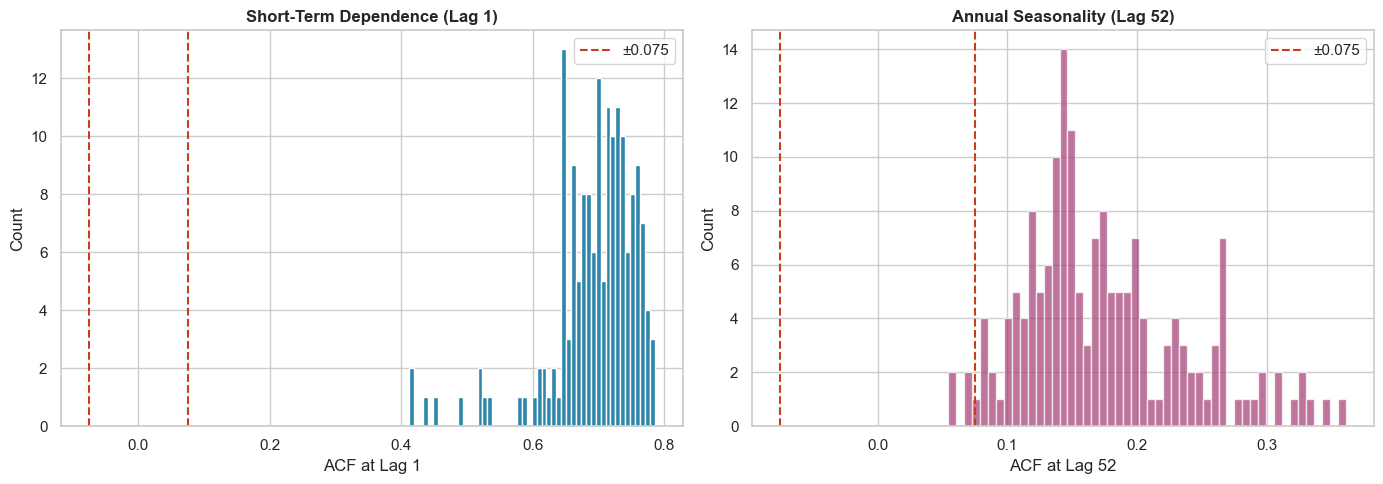


📊 Seasonality Results:
   Mean ACF at Lag 52: 0.1738
   Series with significant annual seasonality: 97.0%
   ✅ Annual cycle (s=52) is a UNIVERSAL FEATURE


In [34]:
# ════════════════════════════════════════════════════════════════
# GLOBAL ACF ANALYSIS
# ════════════════════════════════════════════════════════════════

print("🔄 Computing autocorrelations...")

acf_results = []
for i in range(df_residuals.shape[1]):
    series = df_residuals.iloc[:, i].dropna()
    if len(series) > 52:
        acf_1 = series.autocorr(lag=1)
        acf_52 = series.autocorr(lag=52)
        acf_results.append({'series': i+1, 'acf_1': acf_1, 'acf_52': acf_52})

acf_df = pd.DataFrame(acf_results)
acf_df = acf_df.merge(metadata, on='series')

sig_threshold = 1.96 / np.sqrt(len(df_residuals))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(acf_df['acf_1'].dropna(), bins=50, color=COLORS['primary'], alpha=1, edgecolor='white')
ax.axvline(sig_threshold, color=COLORS['success'], linestyle='--', label=f'±{sig_threshold:.3f}')
ax.axvline(-sig_threshold, color=COLORS['success'], linestyle='--')
ax.set_xlabel('ACF at Lag 1')
ax.set_ylabel('Count')
ax.set_title('Short-Term Dependence (Lag 1)', fontweight='bold')
ax.legend()

ax = axes[1]
ax.hist(acf_df['acf_52'].dropna(), bins=50, color=COLORS['secondary'], alpha=0.7, edgecolor='white')
ax.axvline(sig_threshold, color=COLORS['success'], linestyle='--', label=f'±{sig_threshold:.3f}')
ax.axvline(-sig_threshold, color=COLORS['success'], linestyle='--')
ax.set_xlabel('ACF at Lag 52')
ax.set_ylabel('Count')
ax.set_title('Annual Seasonality (Lag 52)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

seasonal_pct = (acf_df['acf_52'].abs() > sig_threshold).mean() * 100
print(f"\n📊 Seasonality Results:")
print(f"   Mean ACF at Lag 52: {acf_df['acf_52'].mean():.4f}")
print(f"   Series with significant annual seasonality: {seasonal_pct:.1f}%")
print(f"   ✅ Annual cycle (s=52) is a UNIVERSAL FEATURE")

🔄 Computing cross-correlations...


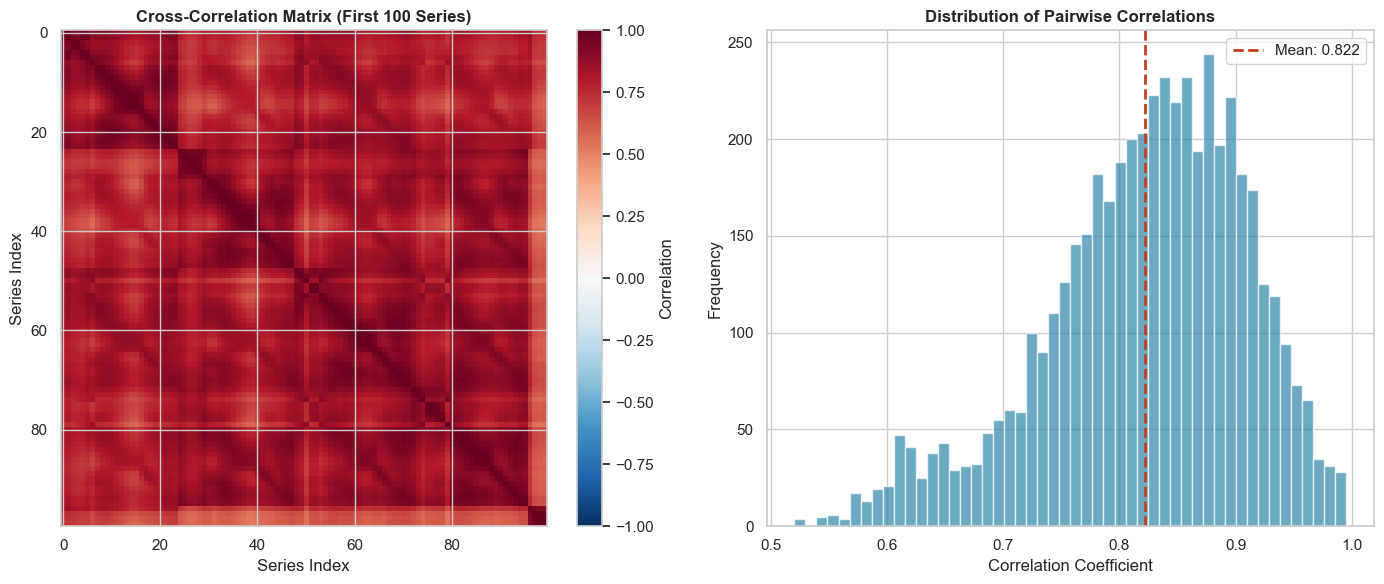


📊 Cross-Correlation Results:
   Mean correlation: 0.8224
   Range: [0.5204, 0.9953]
   ✅ High cross-correlations → COMMON MARKET FORCES
   ✅ Justifies MULTIVARIATE MODELING (VAR)


In [35]:
# ════════════════════════════════════════════════════════════════
# CROSS-CORRELATION ANALYSIS
# ════════════════════════════════════════════════════════════════

print("🔄 Computing cross-correlations...")

n_sample = 100
sample_data = df_residuals.iloc[:, :n_sample]
corr_matrix = sample_data.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
im = ax.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im, ax=ax, label='Correlation')
ax.set_title(f'Cross-Correlation Matrix (First {n_sample} Series)', fontweight='bold')
ax.set_xlabel('Series Index')
ax.set_ylabel('Series Index')

ax = axes[1]
upper_tri = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
ax.hist(upper_tri, bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax.axvline(upper_tri.mean(), color=COLORS['success'], linestyle='--', linewidth=2, 
           label=f'Mean: {upper_tri.mean():.3f}')
ax.set_xlabel('Correlation Coefficient')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Pairwise Correlations', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Cross-Correlation Results:")
print(f"   Mean correlation: {upper_tri.mean():.4f}")
print(f"   Range: [{upper_tri.min():.4f}, {upper_tri.max():.4f}]")
print(f"   ✅ High cross-correlations → COMMON MARKET FORCES")
print(f"   ✅ Justifies MULTIVARIATE MODELING (VAR)")

---
## 5. Clustering Analysis

🔄 Running cluster analysis...
   K=2: Silhouette=0.1597
   K=3: Silhouette=0.1712
   K=4: Silhouette=0.1651
   K=2: Silhouette=0.1597
   K=3: Silhouette=0.1712
   K=4: Silhouette=0.1651
   K=5: Silhouette=0.1687
   K=6: Silhouette=0.1735
   K=7: Silhouette=0.1794
   K=5: Silhouette=0.1687
   K=6: Silhouette=0.1735
   K=7: Silhouette=0.1794
   K=8: Silhouette=0.1703
   K=9: Silhouette=0.1728
   K=10: Silhouette=0.1793
   K=8: Silhouette=0.1703
   K=9: Silhouette=0.1728
   K=10: Silhouette=0.1793
   K=11: Silhouette=0.1718
   K=11: Silhouette=0.1718


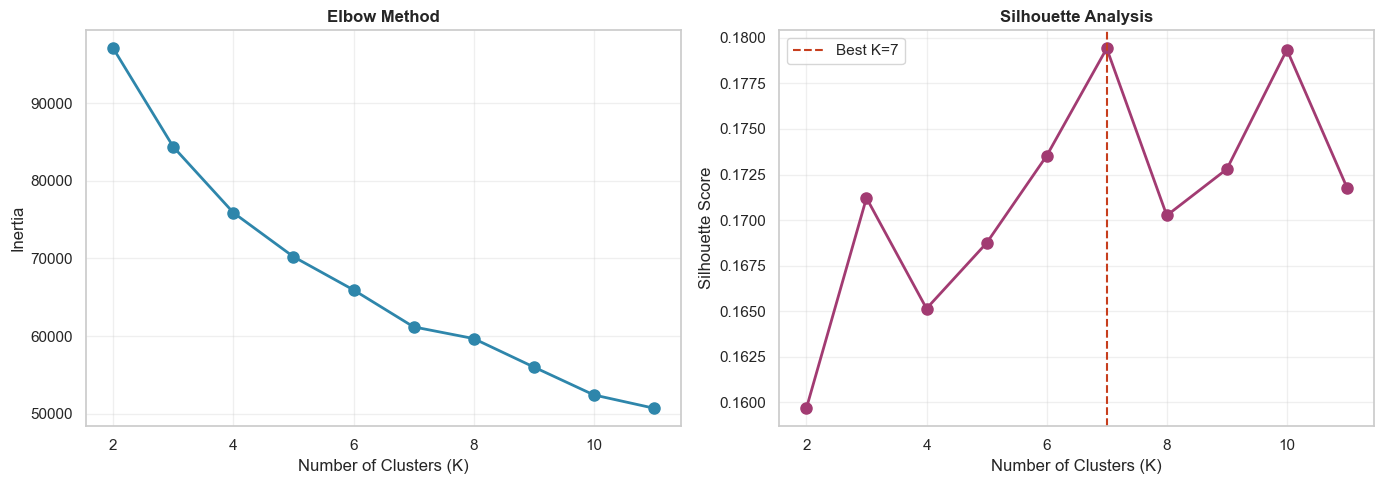

In [36]:
# ════════════════════════════════════════════════════════════════
# K-MEANS CLUSTERING
# ════════════════════════════════════════════════════════════════

# Prepare data for clustering
X = df_residuals.T.values
X = np.nan_to_num(X, nan=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔄 Running cluster analysis...")

K_range = range(2, 12)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    print(f"   K={k}: Silhouette={silhouettes[-1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(K_range, inertias, 'o-', color=COLORS['primary'], linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method', fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(K_range, silhouettes, 'o-', color=COLORS['secondary'], linewidth=2, markersize=8)
best_k = K_range[np.argmax(silhouettes)]
ax.axvline(best_k, color=COLORS['success'], linestyle='--', label=f'Best K={best_k}')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Analysis', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
best_k 

7

🎯 Fitting final model with K=7...
   series       day  day_idx  hour           region  is_weekend  is_weekday  \
0       0  Thursday        0     1  New England Avg       False        True   
1       1  Thursday        0     2  New England Avg       False        True   
2       2  Thursday        0     3  New England Avg       False        True   
3       3  Thursday        0     4  New England Avg       False        True   
4       4  Thursday        0     5  New England Avg       False        True   

   is_peak time_of_day  cluster  
0    False       night        1  
1    False       night        1  
2    False       night        1  
3    False       night        1  
4    False       night        1  
new_metadata shape: (168, 10), cluster_labels shape: (168,)

📊 Cluster Sizes:
   Cluster 1: 41 series (24.4%)
   Cluster 2: 32 series (19.0%)
   Cluster 3: 12 series (7.1%)
   Cluster 4: 12 series (7.1%)
   Cluster 5: 14 series (8.3%)
   Cluster 6: 24 series (14.3%)
   Cluster 7: 33 ser

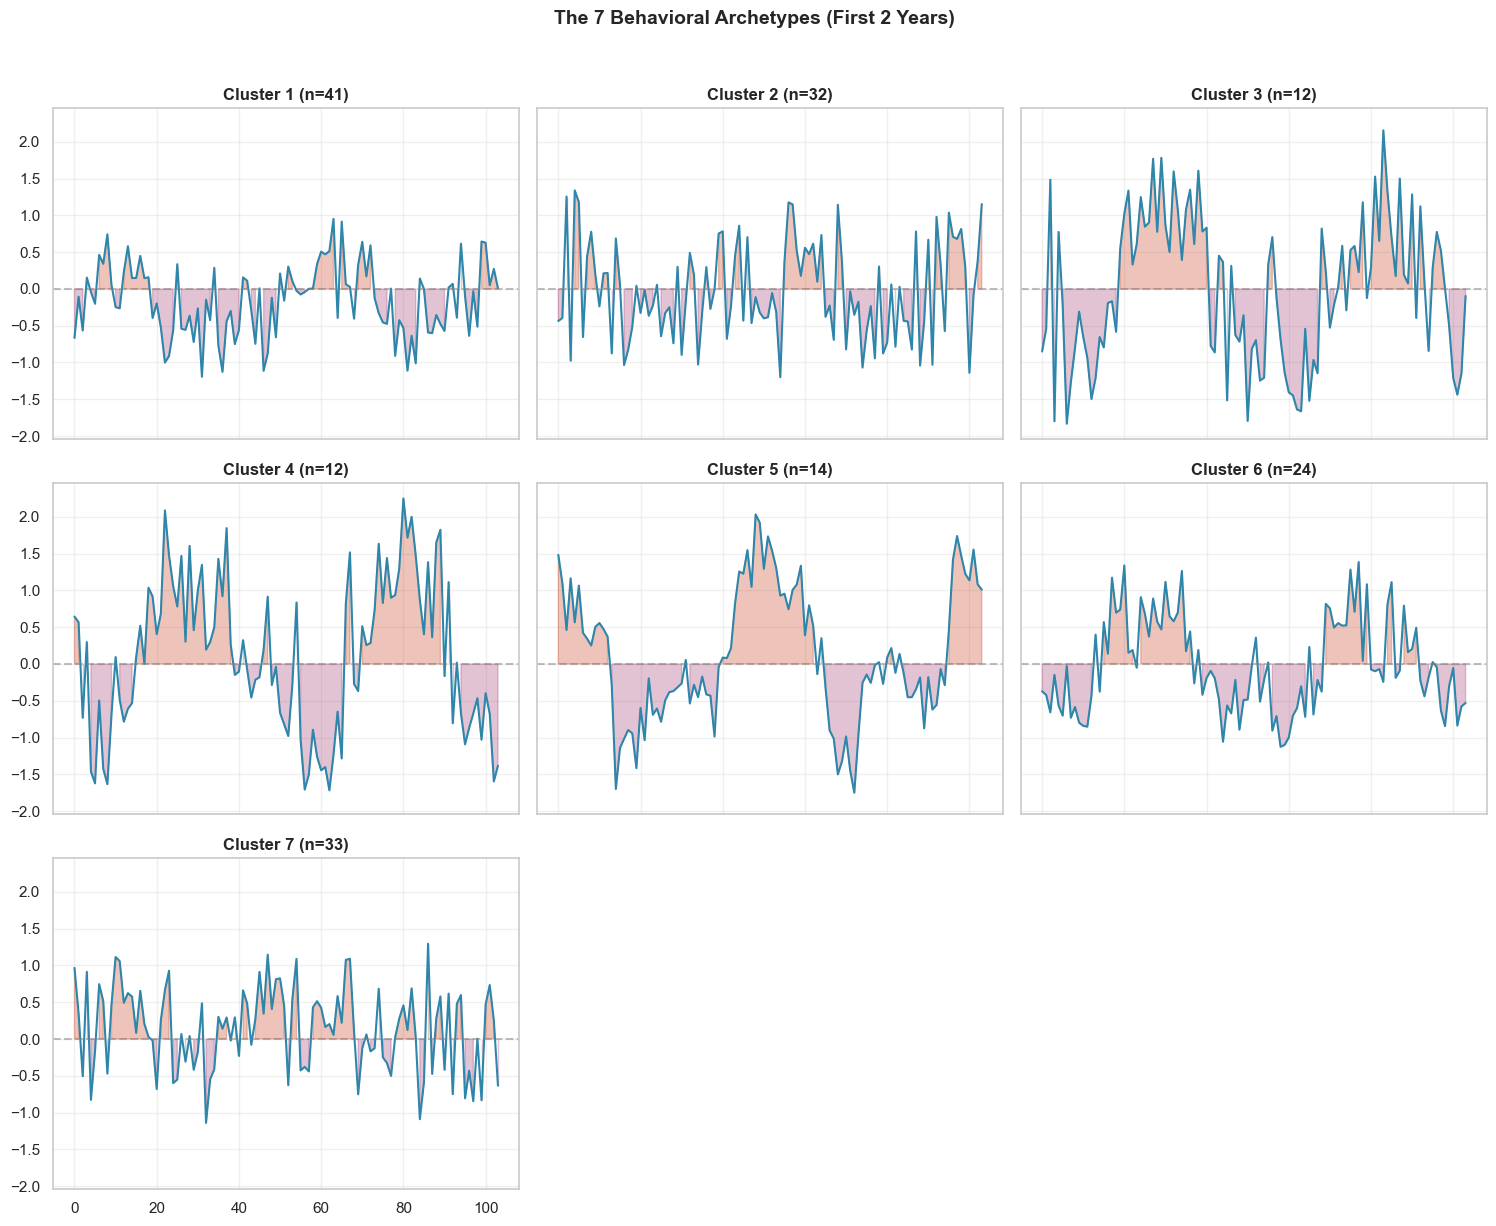

In [ ]:
# ════════════════════════════════════════════════════════════════
# FINAL CLUSTERING & VISUALIZATION
# ════════════════════════════════════════════════════════════════

# k_final = min(9, best_k + 2) # why ?????
# print(f"🎯 Fitting final model with K={k_final}...")

k_final = best_k
print(f"🎯 Fitting final model with K={k_final}...")
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
centroids = kmeans_final.cluster_centers_

new_metadata['cluster'] = cluster_labels

print(new_metadata.head())
print(f"new_metadata shape: {new_metadata.shape}, cluster_labels shape: {cluster_labels.shape}")

print("\n📊 Cluster Sizes:")
for i in range(k_final):
    count = (cluster_labels == i).sum()
    print(f"   Cluster {i+1}: {count} series ({count/len(cluster_labels)*100:.1f}%)")

# Plot centroids
n_rows = (k_final + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows), sharex=True, sharey=True)
axes = axes.flatten()

time_steps = min(104, centroids.shape[1])

for i in range(k_final):
    ax = axes[i]
    count = (cluster_labels == i).sum()
    ax.plot(centroids[i, :time_steps], color=COLORS['primary'], linewidth=1.5)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.fill_between(range(time_steps), 0, centroids[i, :time_steps], 
                    where=centroids[i, :time_steps] > 0, alpha=0.3, color=COLORS['success'])
    ax.fill_between(range(time_steps), 0, centroids[i, :time_steps], 
                    where=centroids[i, :time_steps] < 0, alpha=0.3, color=COLORS['secondary'])
    ax.set_title(f'Cluster {i+1} (n={count})', fontweight='bold')
    ax.grid(True, alpha=0.3)

for i in range(k_final, len(axes)):
    axes[i].set_visible(False)

plt.suptitle(f'The {k_final} Behavioral Archetypes (First 2 Years)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

🔍 Analyzing cluster composition...



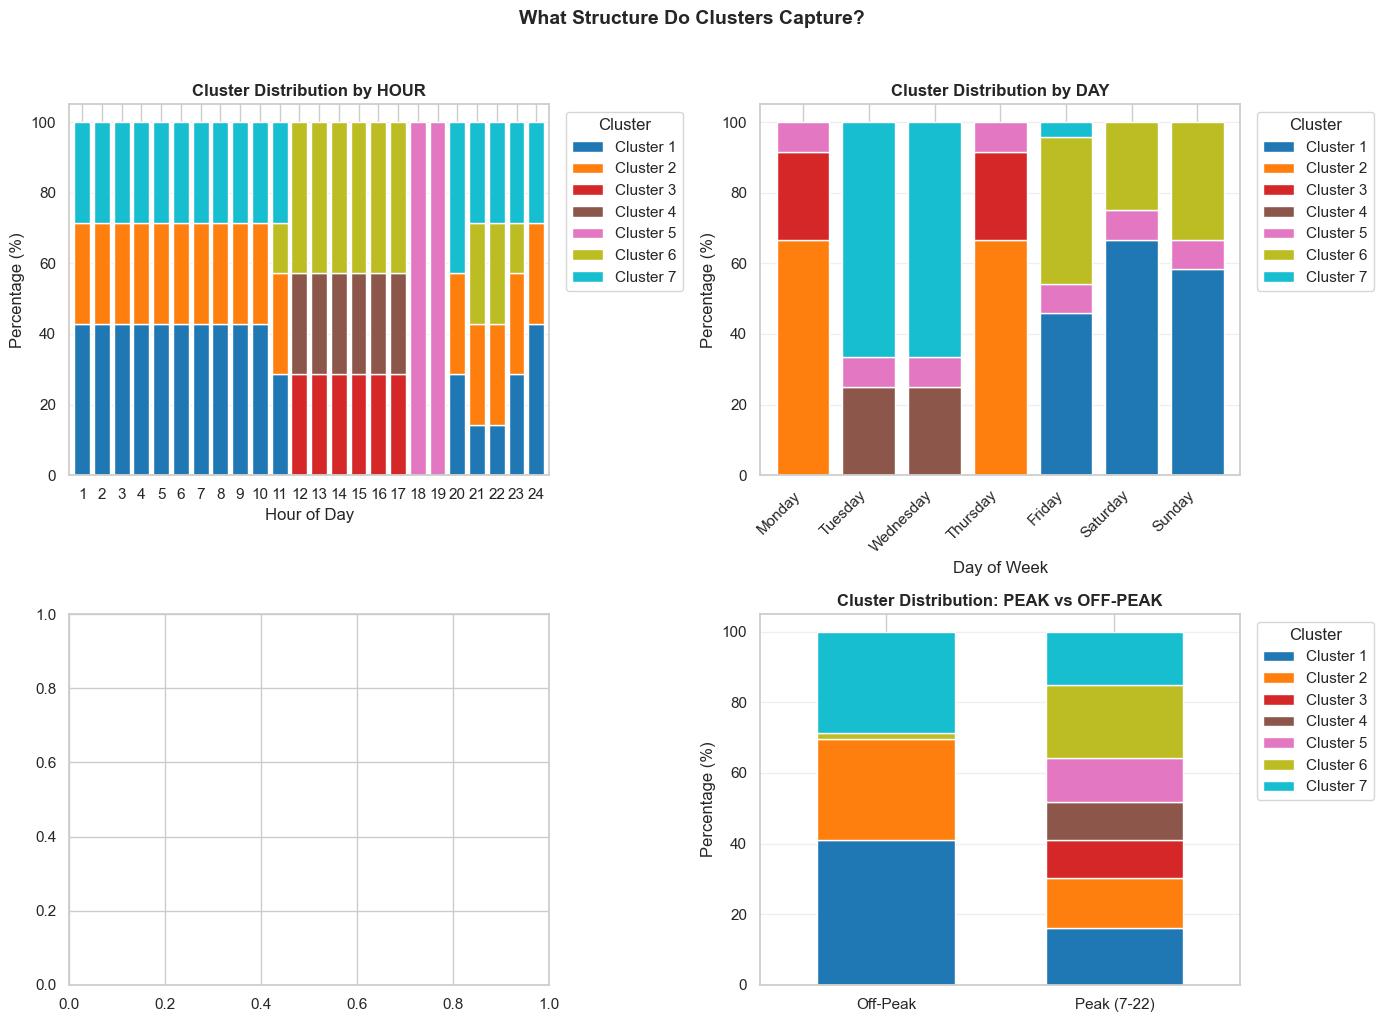

In [48]:
# ════════════════════════════════════════════════════════════════
# CLUSTER CHARACTERIZATION: WHAT STRUCTURE DO CLUSTERS CAPTURE?
# ════════════════════════════════════════════════════════════════

print("🔍 Analyzing cluster composition...\n")

# Add cluster labels to metadata
new_metadata['cluster'] = cluster_labels
new_metadata['cluster_name'] = new_metadata['cluster'].apply(lambda x: f'Cluster {x+1}')

# ════════════════════════════════════════════════════════════════
# 1. CLUSTER COMPOSITION BY HOUR
# ════════════════════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hour distribution
ax = axes[0, 0]
hour_cluster = pd.crosstab(new_metadata['hour'], new_metadata['cluster_name'], normalize='index') * 100
hour_cluster.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Percentage (%)')
ax.set_title('Cluster Distribution by HOUR', fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(range(1, 25), rotation=0)
ax.grid(True, alpha=0.3, axis='y')

# Day distribution
ax = axes[0, 1]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_metadata['day'] = pd.Categorical(new_metadata['day'], categories=day_order, ordered=True)
day_cluster = pd.crosstab(new_metadata['day'], new_metadata['cluster_name'], normalize='index') * 100
day_cluster.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percentage (%)')
ax.set_title('Cluster Distribution by DAY', fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(day_order, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# # Region distribution
# ax = axes[1, 0]
# region_cluster = pd.crosstab(metadata['region'], metadata['cluster_name'], normalize='index') * 100
# region_cluster.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
# ax.set_xlabel('Region')
# ax.set_ylabel('Percentage (%)')
# ax.set_title('Cluster Distribution by REGION', fontweight='bold')
# ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
# ax.grid(True, alpha=0.3, axis='y')

# Peak vs Off-Peak
ax = axes[1, 1]
peak_cluster = pd.crosstab(new_metadata['is_peak'].map({True: 'Peak (7-22)', False: 'Off-Peak'}), 
                           new_metadata['cluster_name'], normalize='index') * 100
peak_cluster.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.6)
ax.set_xlabel('')
ax.set_ylabel('Percentage (%)')
ax.set_title('Cluster Distribution: PEAK vs OFF-PEAK', fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('What Structure Do Clusters Capture?', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

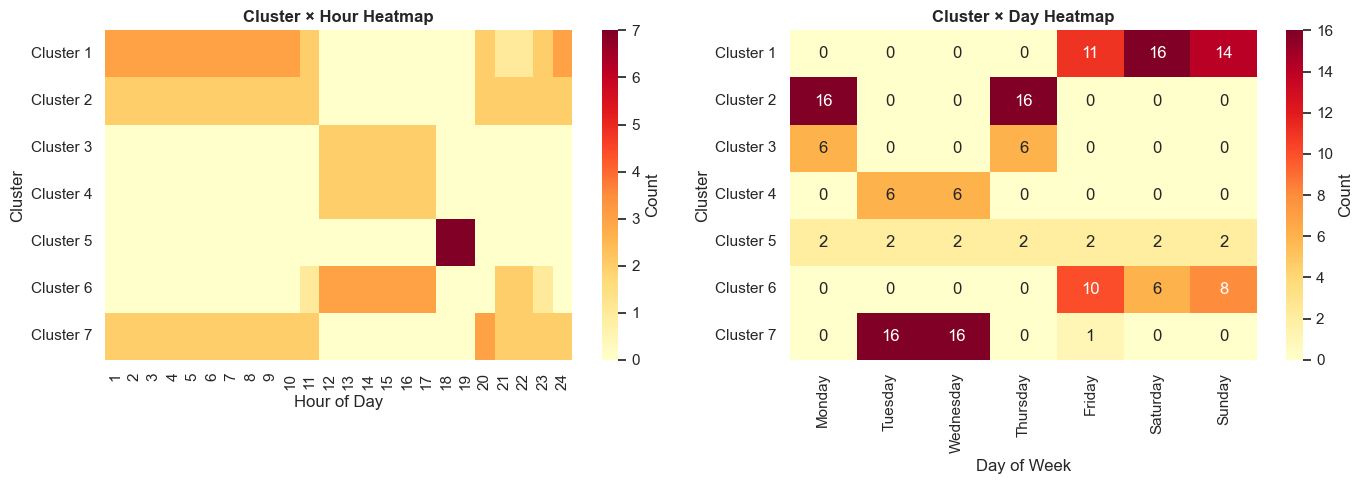

In [49]:
# ════════════════════════════════════════════════════════════════
# 2. HEATMAP: CLUSTER × HOUR × DAY
# ════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster by Hour heatmap
ax = axes[0]
hour_counts = pd.crosstab(new_metadata['cluster_name'], new_metadata['hour'])
sns.heatmap(hour_counts, annot=False, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Cluster')
ax.set_title('Cluster × Hour Heatmap', fontweight='bold')

# Cluster by Day heatmap
ax = axes[1]
day_counts = pd.crosstab(new_metadata['cluster_name'], new_metadata['day'])
sns.heatmap(day_counts, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Day of Week')
ax.set_ylabel('Cluster')
ax.set_title('Cluster × Day Heatmap', fontweight='bold')

plt.tight_layout()
plt.show()

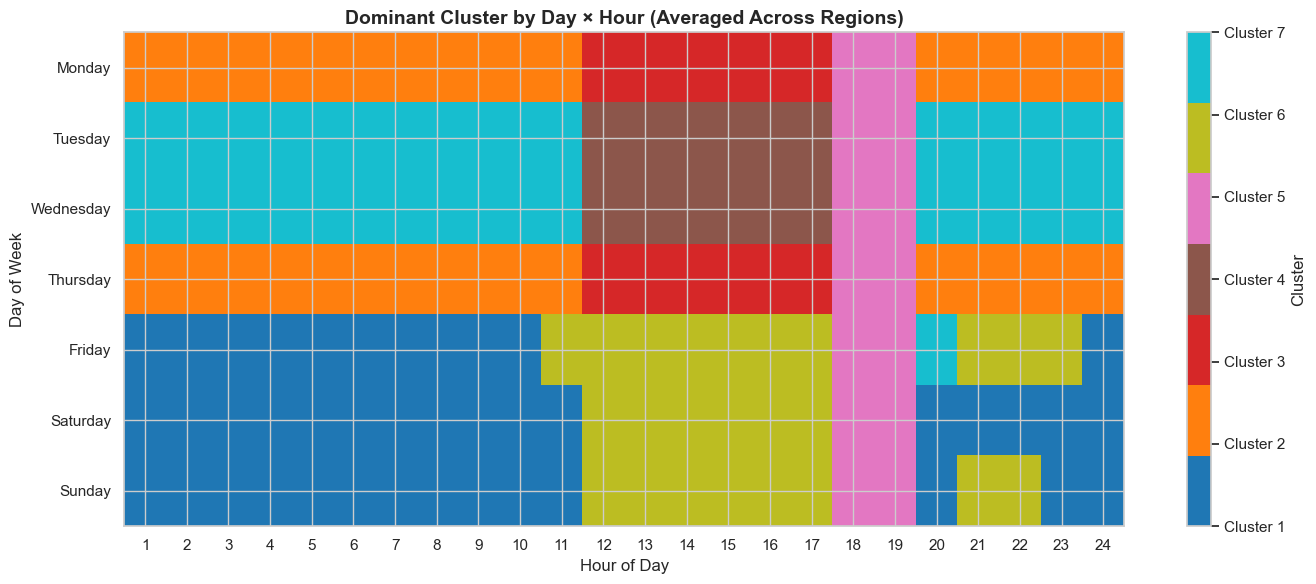


🔍 Interpretation:
   • Similar colors in rows → Clusters capture HOUR patterns
   • Similar colors in columns → Clusters capture DAY patterns
   • Uniform color → No clear day/hour structure (maybe region-based)


In [50]:
# ════════════════════════════════════════════════════════════════
# 4. VISUALIZE CLUSTER STRUCTURE: HOUR × DAY GRID
# ════════════════════════════════════════════════════════════════

# Create a pivot showing which cluster dominates each hour-day combination
# For each (day, hour), find the most common cluster

dominant_cluster = new_metadata.groupby(['day', 'hour'])['cluster'].agg(lambda x: x.mode()[0]).unstack()
dominant_cluster = dominant_cluster.reindex(day_order)

fig, ax = plt.subplots(figsize=(14, 6))

# Custom colormap for clusters
cmap = plt.cm.get_cmap('tab10', k_final)

im = ax.imshow(dominant_cluster.values, aspect='auto', cmap=cmap, vmin=0, vmax=k_final-1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=range(k_final))
cbar.set_label('Cluster')
cbar.set_ticklabels([f'Cluster {i+1}' for i in range(k_final)])

ax.set_xticks(range(24))
ax.set_xticklabels(range(1, 25))
ax.set_yticks(range(7))
ax.set_yticklabels(day_order)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
ax.set_title('Dominant Cluster by Day × Hour (Averaged Across Regions)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n🔍 Interpretation:")
print("   • Similar colors in rows → Clusters capture HOUR patterns")
print("   • Similar colors in columns → Clusters capture DAY patterns")
print("   • Uniform color → No clear day/hour structure (maybe region-based)")

# Univariate Series Extraction and Analysis for Each Cluster
For each cluster, we extract a representative univariate series and perform a full time series analysis (visualization, stationarity, autocorrelation, and seasonality) to understand the pattern behind each cluster.

In [57]:
# For each cluster, extract a representative univariate series (e.g., the series closest to the cluster centroid)
from scipy.spatial.distance import cdist

# Use the reduced feature space (e.g., df_avg or cluster_series)
# Here, we assume cluster_series (log-prices, shape: weeks × clusters) and new_metadata (168 rows)

# If you want to use the original (not averaged) data, adapt accordingly

univariate_examples = {}
for i in range(k_final):
    # Get indices of series in cluster i
    idx = new_metadata[new_metadata['cluster'] == i].index
    # Get the cluster centroid
    centroid = kmeans_final.cluster_centers_[i]
    # Find the series closest to the centroid (in scaled space)
    cluster_X = X_scaled[idx]
    dists = cdist(cluster_X, [centroid])
    closest_idx = idx[dists.argmin()]
    # Extract the original (unscaled) series for analysis
    univariate_examples[i] = df_avg.iloc[:, closest_idx]
    print(f"Cluster {i+1}: extracted series at (day, hour) = {new_metadata.loc[closest_idx, ['day', 'hour']].to_dict()}")

Cluster 1: extracted series at (day, hour) = {'day': 'Sunday', 'hour': 10}
Cluster 2: extracted series at (day, hour) = {'day': 'Monday', 'hour': 23}
Cluster 3: extracted series at (day, hour) = {'day': 'Thursday', 'hour': 14}
Cluster 4: extracted series at (day, hour) = {'day': 'Wednesday', 'hour': 14}
Cluster 5: extracted series at (day, hour) = {'day': 'Sunday', 'hour': 19}
Cluster 6: extracted series at (day, hour) = {'day': 'Sunday', 'hour': 14}
Cluster 7: extracted series at (day, hour) = {'day': 'Tuesday', 'hour': 23}



Cluster 1 Representative Series Analysis


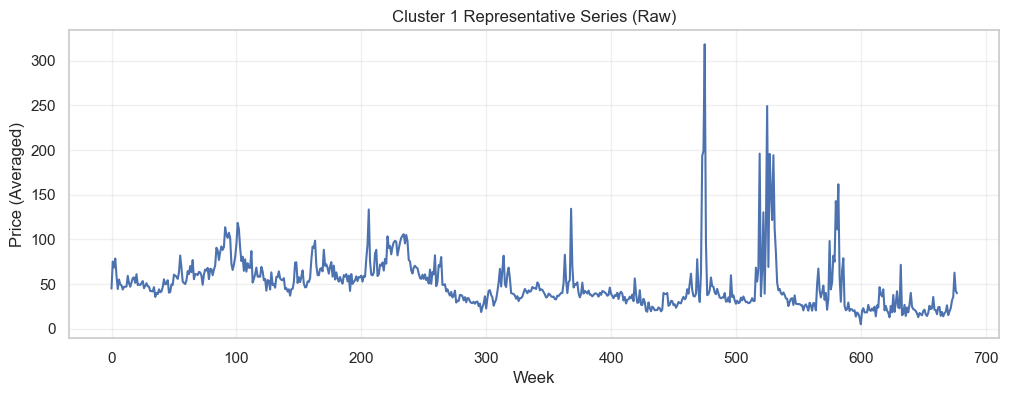

ADF Statistic: -5.481, p-value: 0.0000
→ Series is stationary (reject H0)


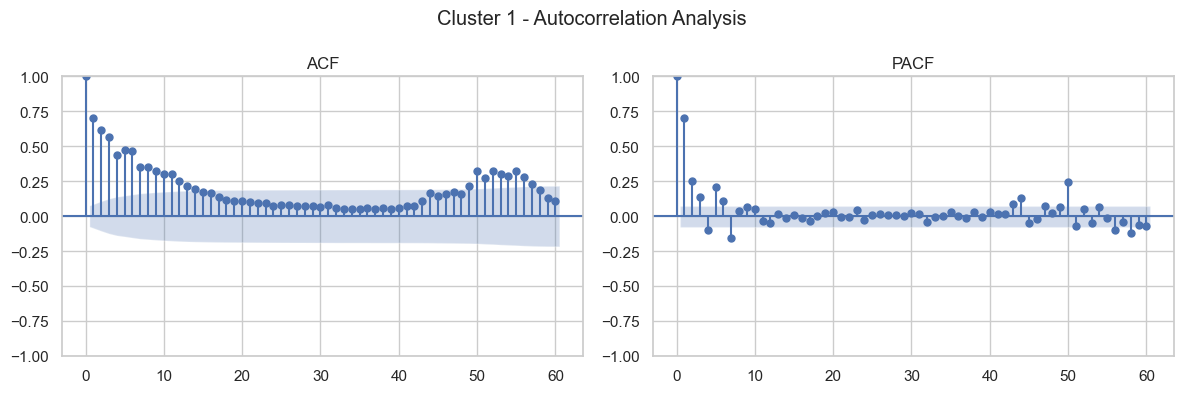

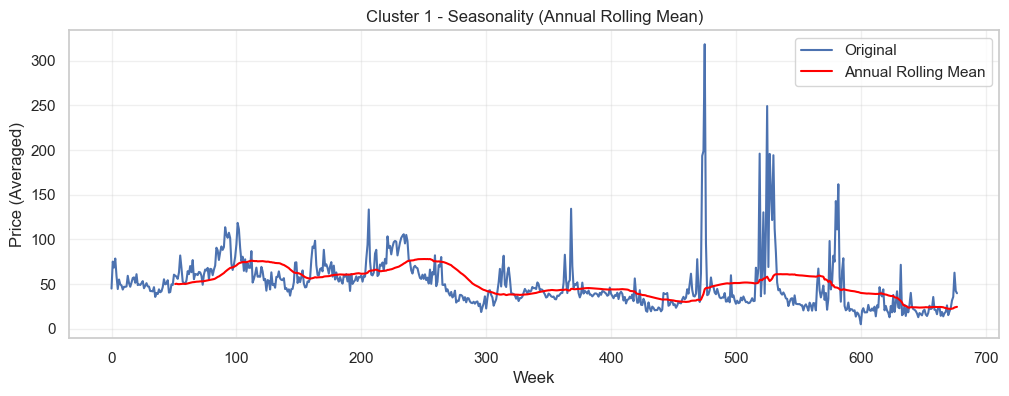


Cluster 2 Representative Series Analysis


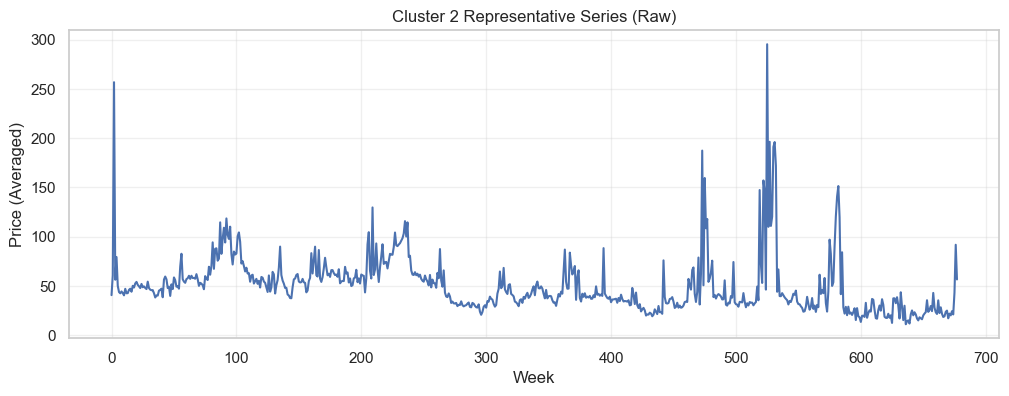

ADF Statistic: -6.177, p-value: 0.0000
→ Series is stationary (reject H0)


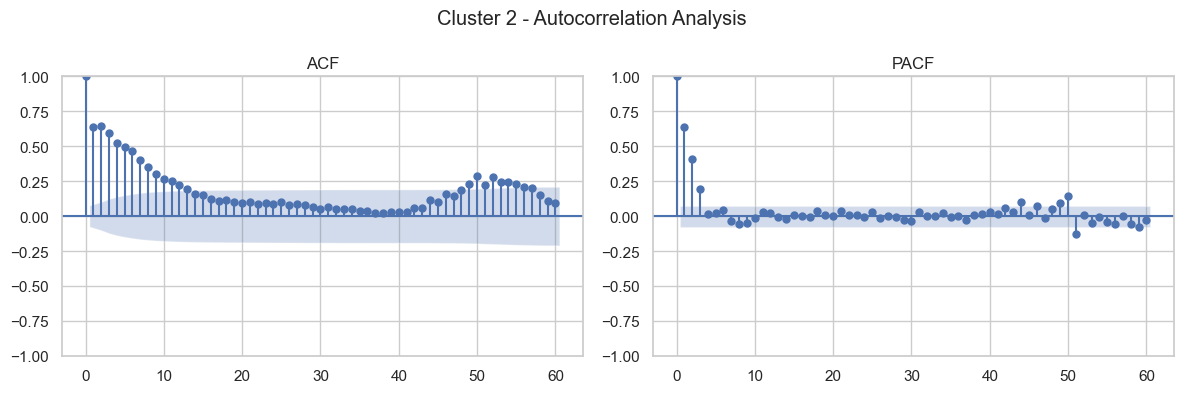

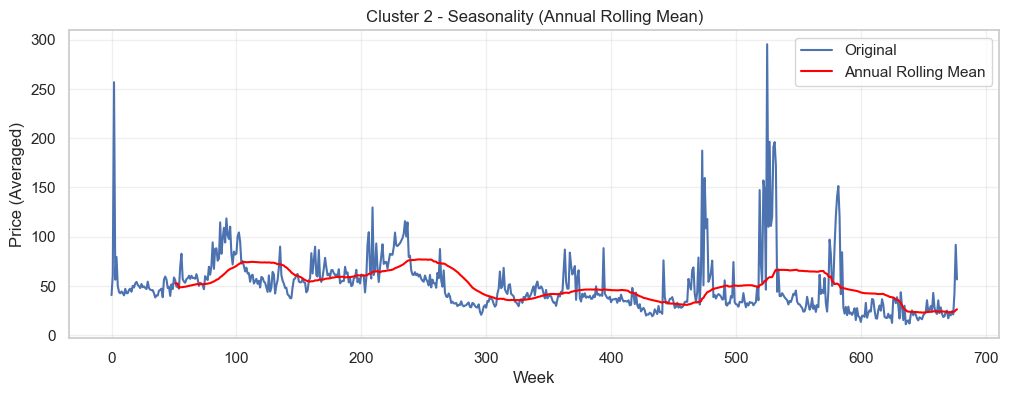


Cluster 3 Representative Series Analysis


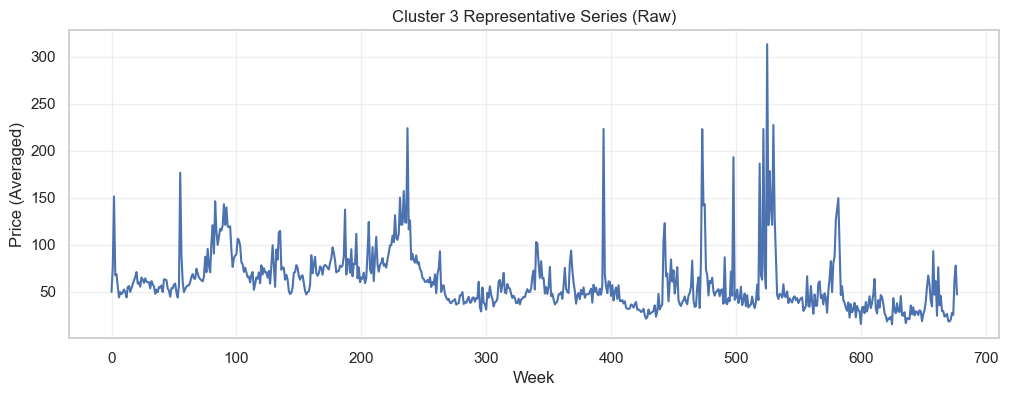

ADF Statistic: -5.433, p-value: 0.0000
→ Series is stationary (reject H0)


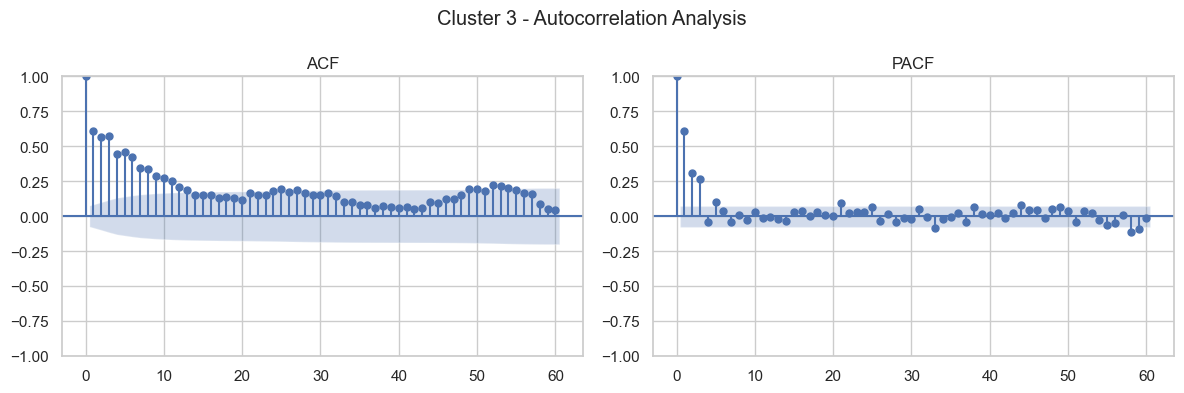

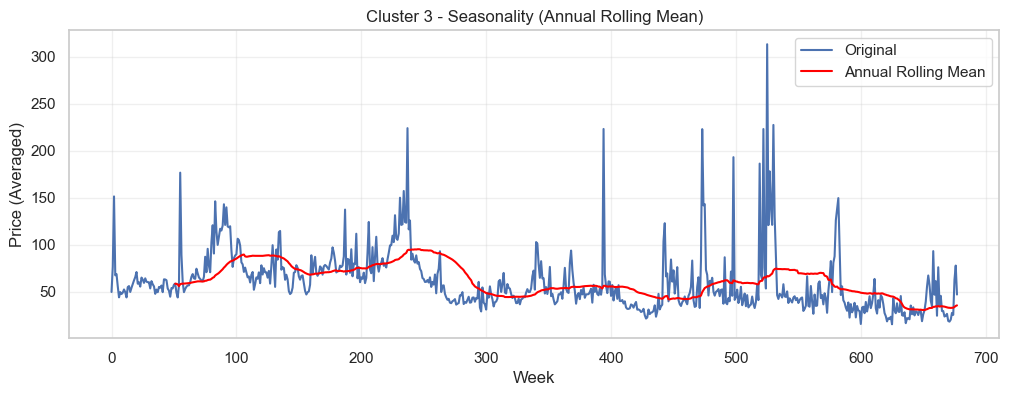


Cluster 4 Representative Series Analysis


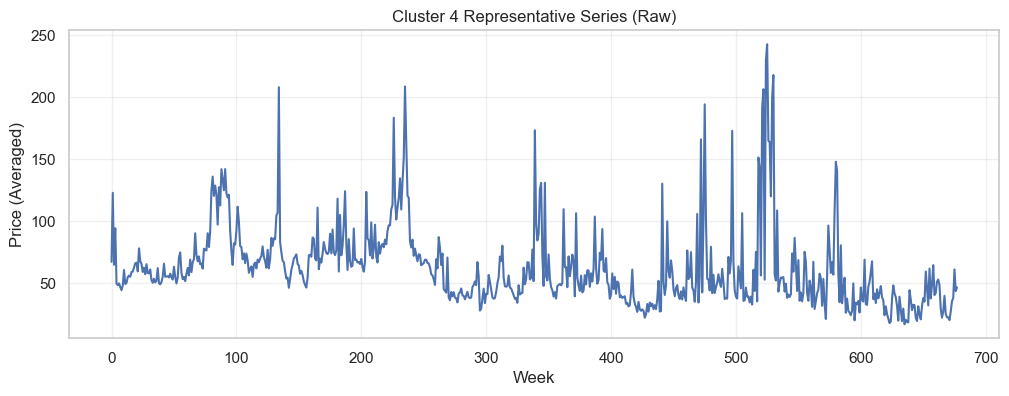

ADF Statistic: -5.321, p-value: 0.0000
→ Series is stationary (reject H0)


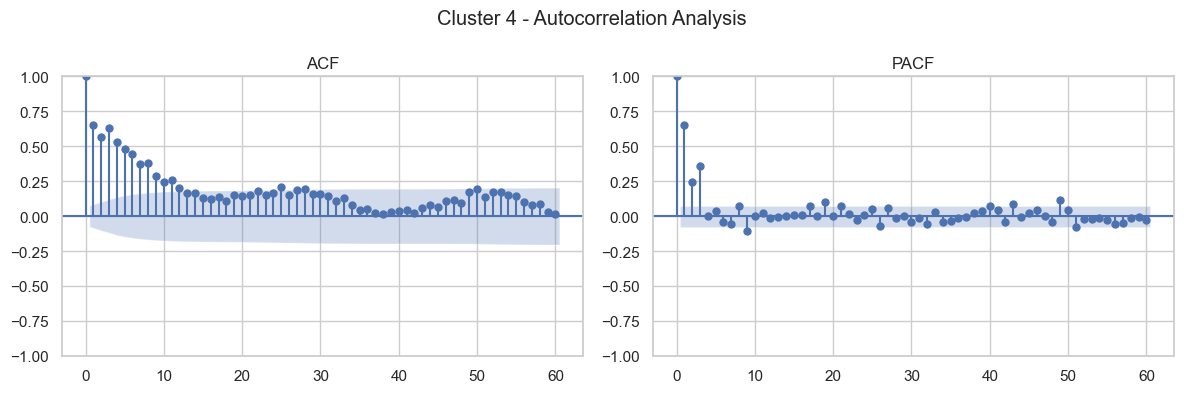

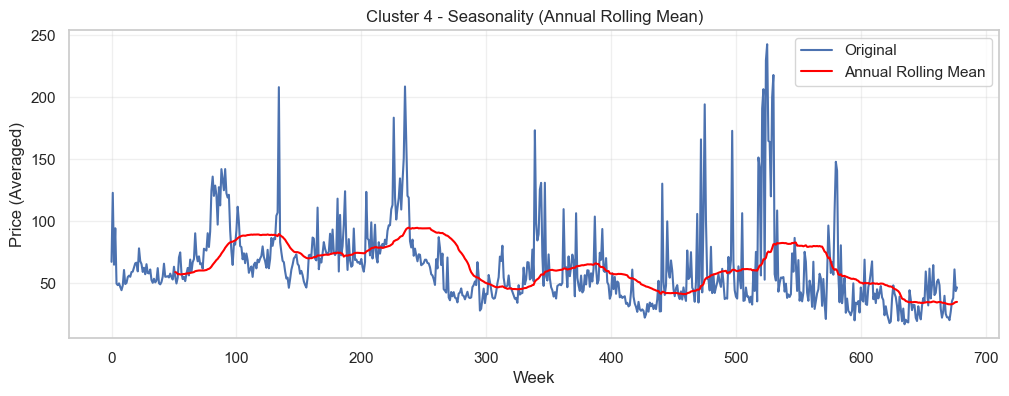


Cluster 5 Representative Series Analysis


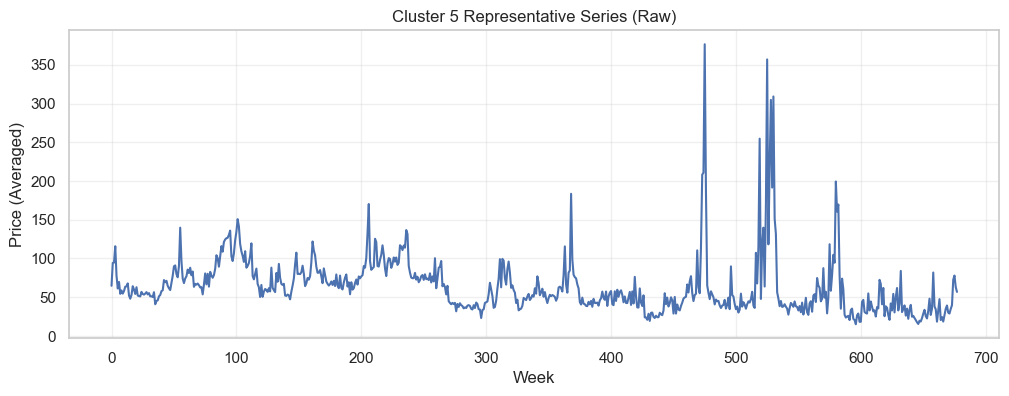

ADF Statistic: -5.285, p-value: 0.0000
→ Series is stationary (reject H0)


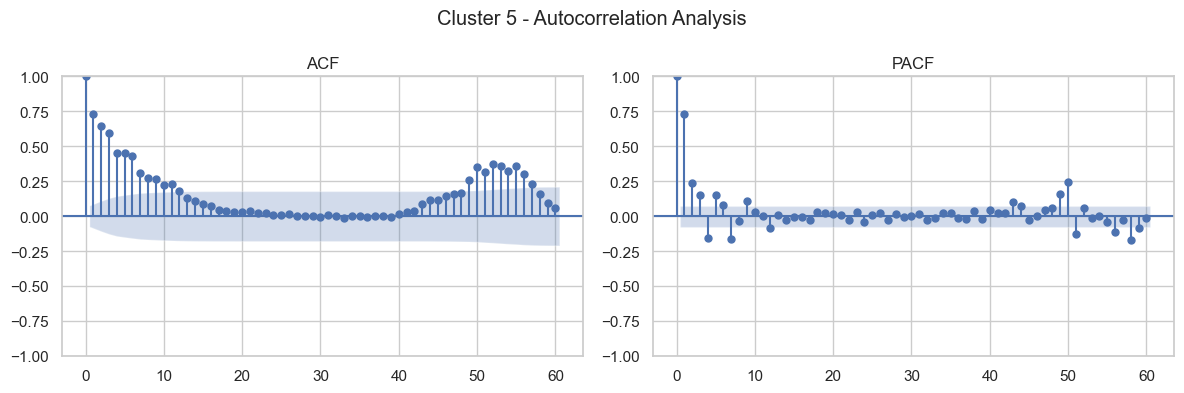

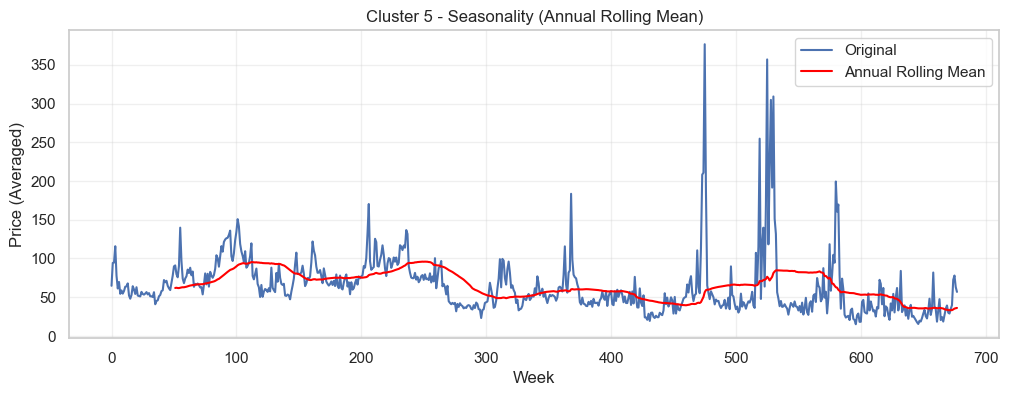


Cluster 6 Representative Series Analysis


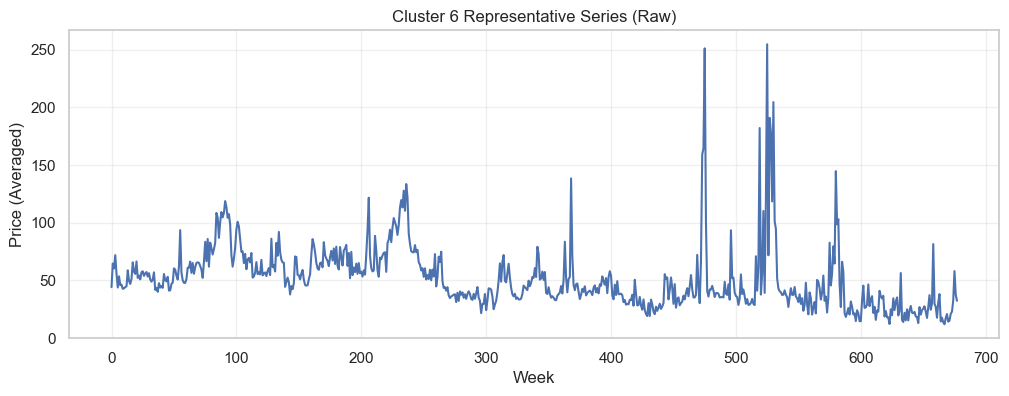

ADF Statistic: -4.689, p-value: 0.0001
→ Series is stationary (reject H0)


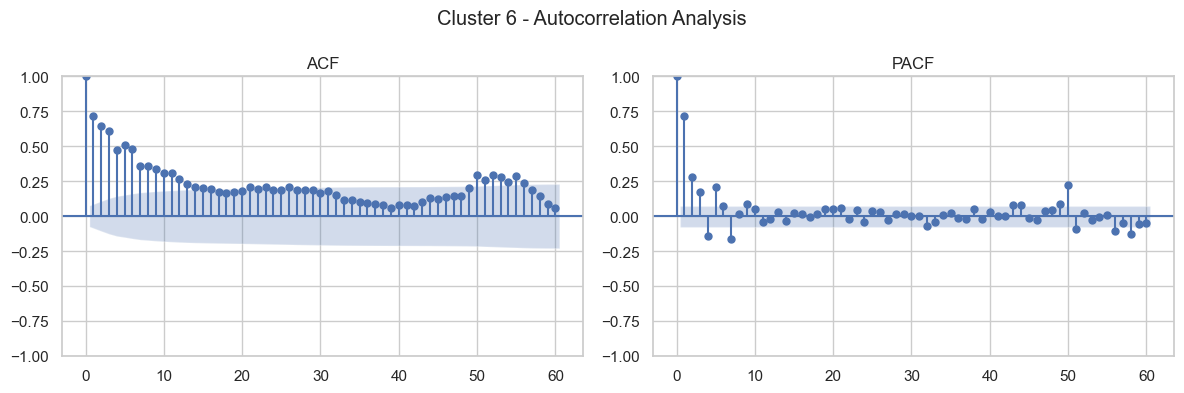

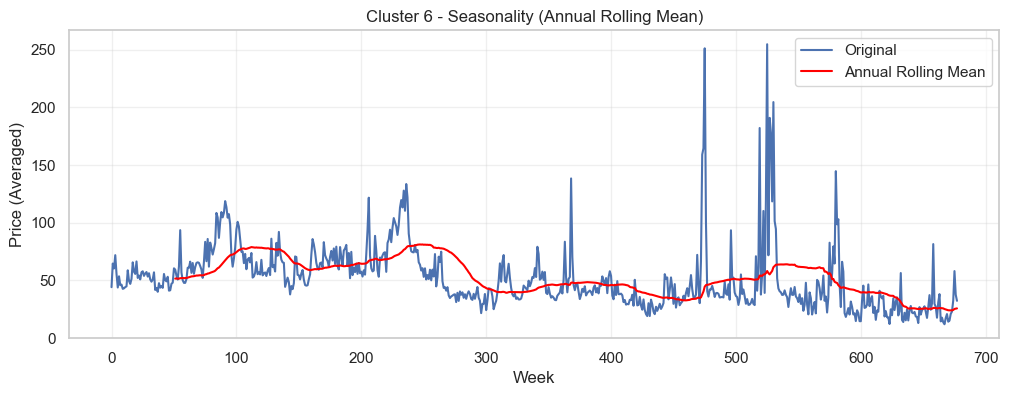


Cluster 7 Representative Series Analysis


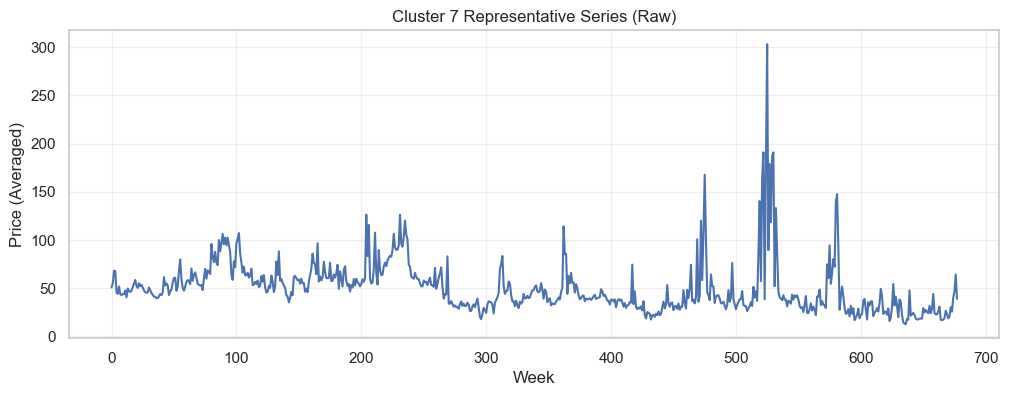

ADF Statistic: -5.597, p-value: 0.0000
→ Series is stationary (reject H0)


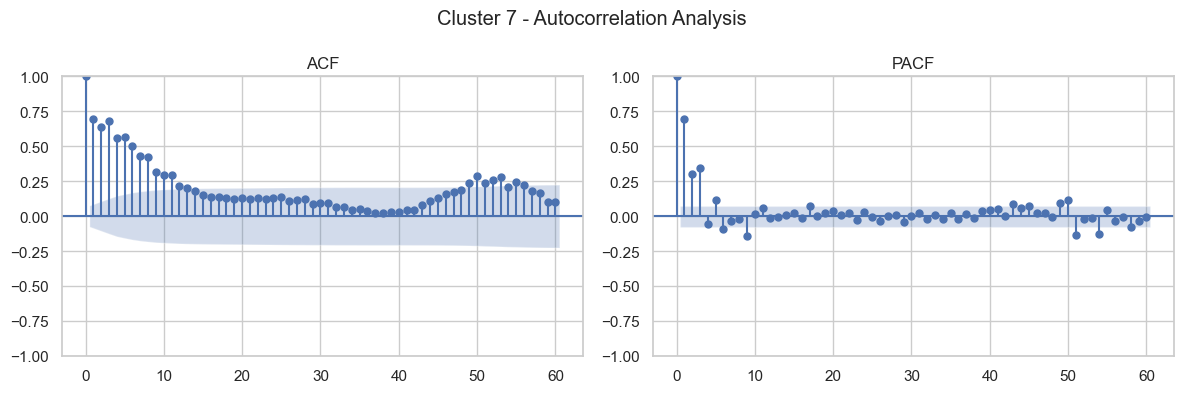

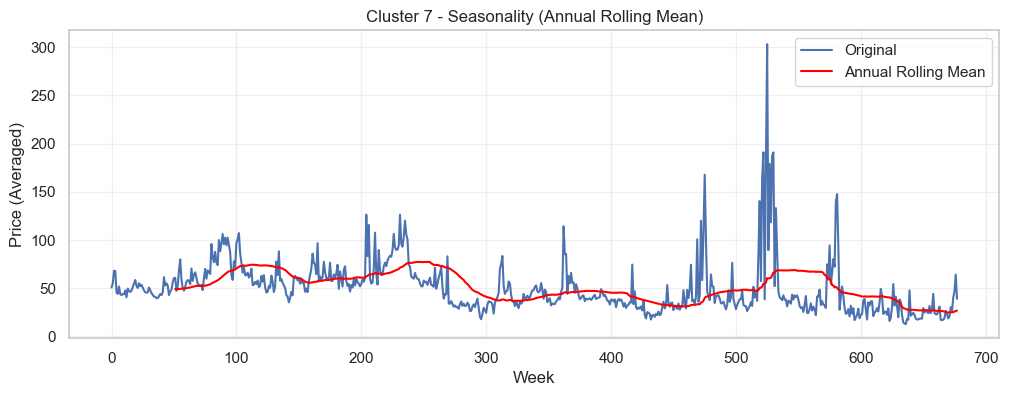

In [59]:
# Full analysis for each extracted univariate series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i, series in univariate_examples.items():
    print(f"\n{'='*60}\nCluster {i+1} Representative Series Analysis\n{'='*60}")
    plt.figure(figsize=(12, 4))
    plt.plot(series.values)
    plt.title(f'Cluster {i+1} Representative Series (Raw)')
    plt.xlabel('Week')
    plt.ylabel('Price (Averaged)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Stationarity test
    adf_result = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.4f}")
    if adf_result[1] < 0.05:
        print("→ Series is stationary (reject H0)")
    else:
        print("→ Series is NOT stationary (fail to reject H0)")
    
    # Autocorrelation
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series.dropna(), lags=60, ax=axes[0])
    plot_pacf(series.dropna(), lags=60, ax=axes[1])
    axes[0].set_title('ACF')
    axes[1].set_title('PACF')
    plt.suptitle(f'Cluster {i+1} - Autocorrelation Analysis')
    plt.tight_layout()
    plt.show()
    
    # Seasonality (rolling mean)
    plt.figure(figsize=(12, 4))
    plt.plot(series.values, label='Original')
    plt.plot(pd.Series(series).rolling(window=52).mean(), label='Annual Rolling Mean', color='red')
    plt.title(f'Cluster {i+1} - Seasonality (Annual Rolling Mean)')
    plt.xlabel('Week')
    plt.ylabel('Price (Averaged)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

We fit a SARIMA(4, 0, 13)(1, 0, 1, 52) model to each cluster's representative univariate series to capture persistence and annual seasonality (lag 52).



Cluster 1 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                        ('Sunday', 10)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2687.110
Date:                               Tue, 03 Feb 2026   AIC                           5414.220
Time:                                       00:07:22   BIC                           5502.554
Sample:                                            0   HQIC                          5448.576
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6443      0.887      0.726      0

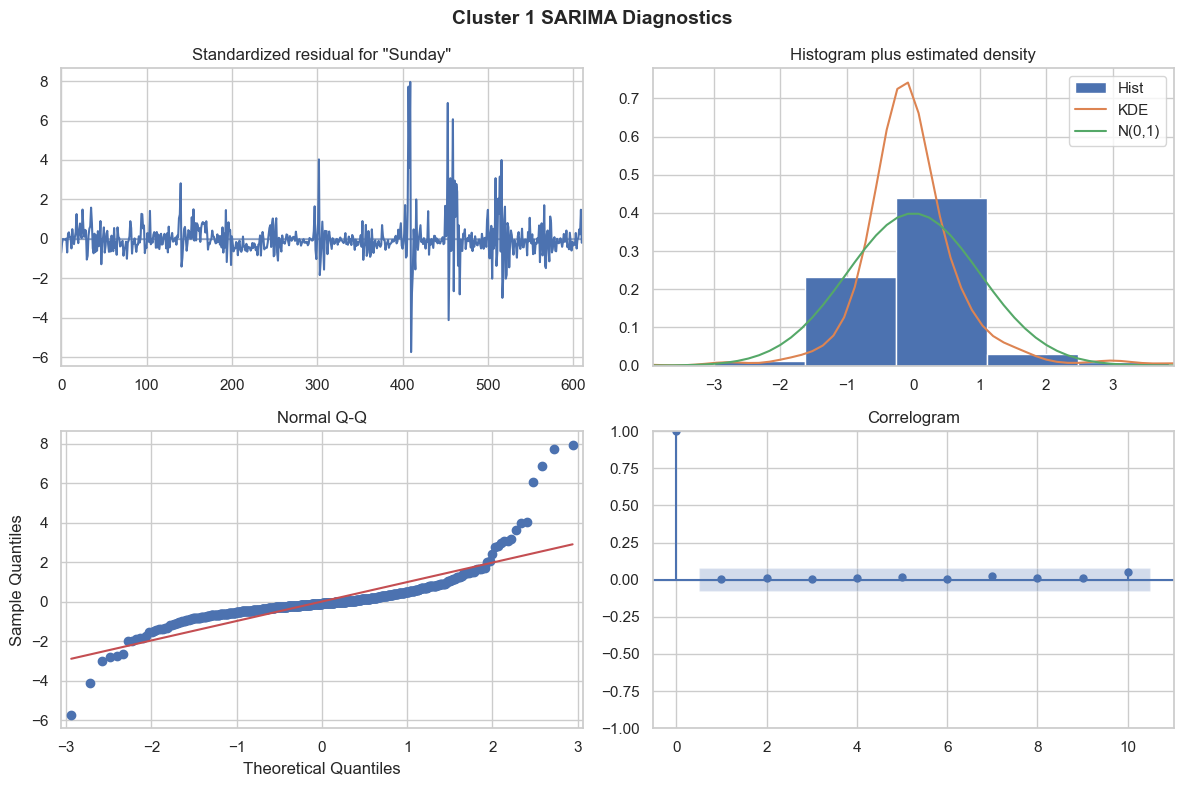

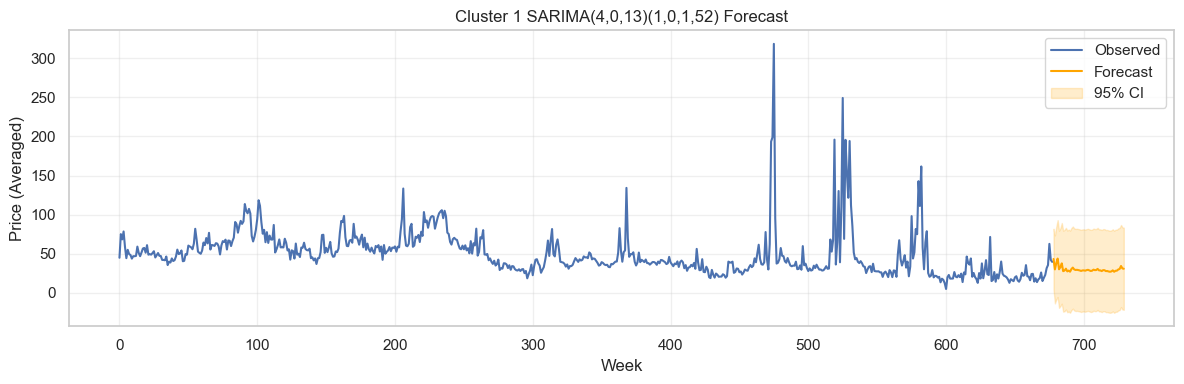


Cluster 2 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                      ('Thursday', 23)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2659.246
Date:                               Tue, 03 Feb 2026   AIC                           5358.492
Time:                                       00:09:12   BIC                           5446.827
Sample:                                            0   HQIC                          5392.848
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6739      1.214      0.555      0

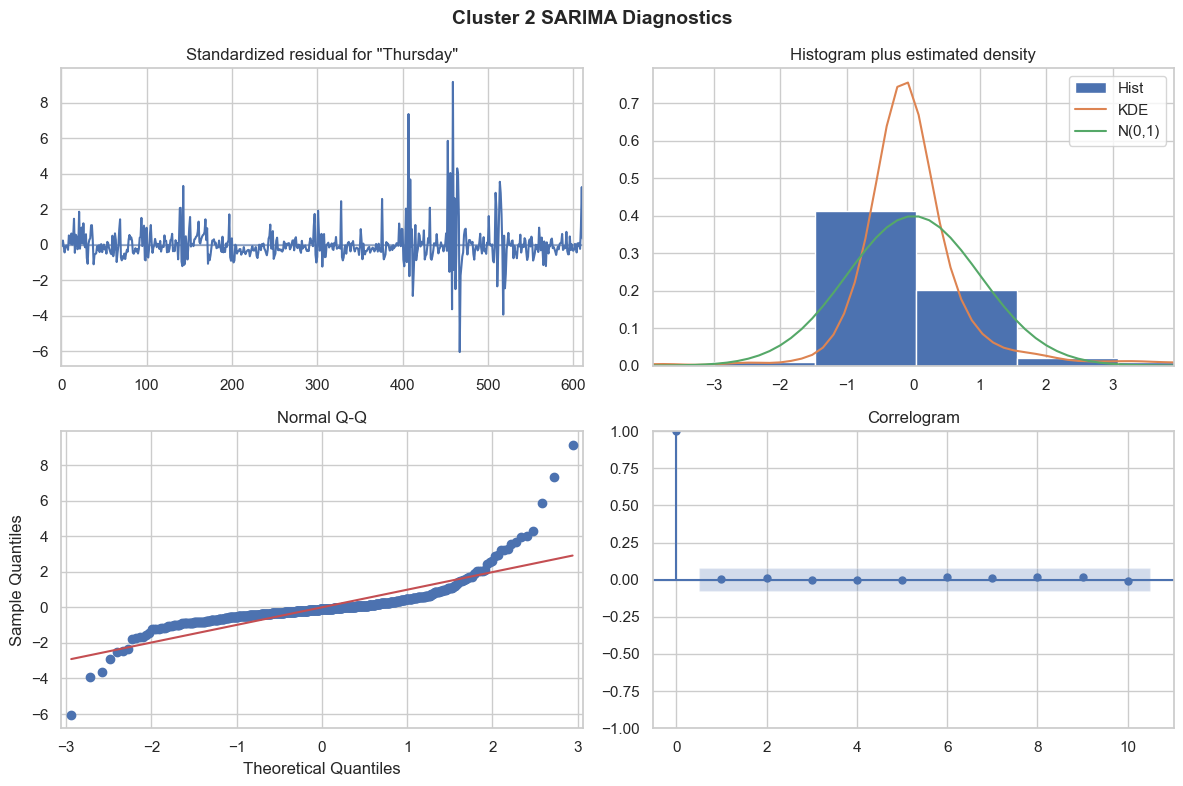

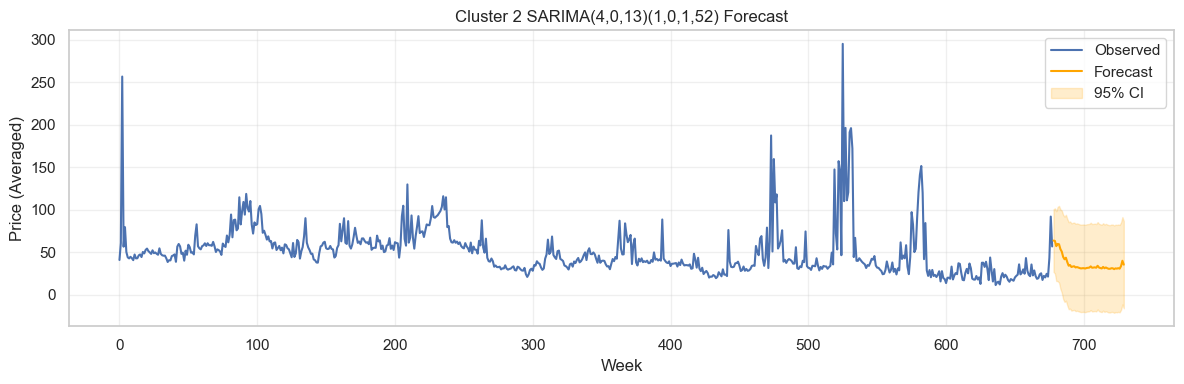


Cluster 3 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                        ('Friday', 14)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2795.856
Date:                               Tue, 03 Feb 2026   AIC                           5631.712
Time:                                       00:10:52   BIC                           5720.046
Sample:                                            0   HQIC                          5666.068
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5772      1.094      0.528      0

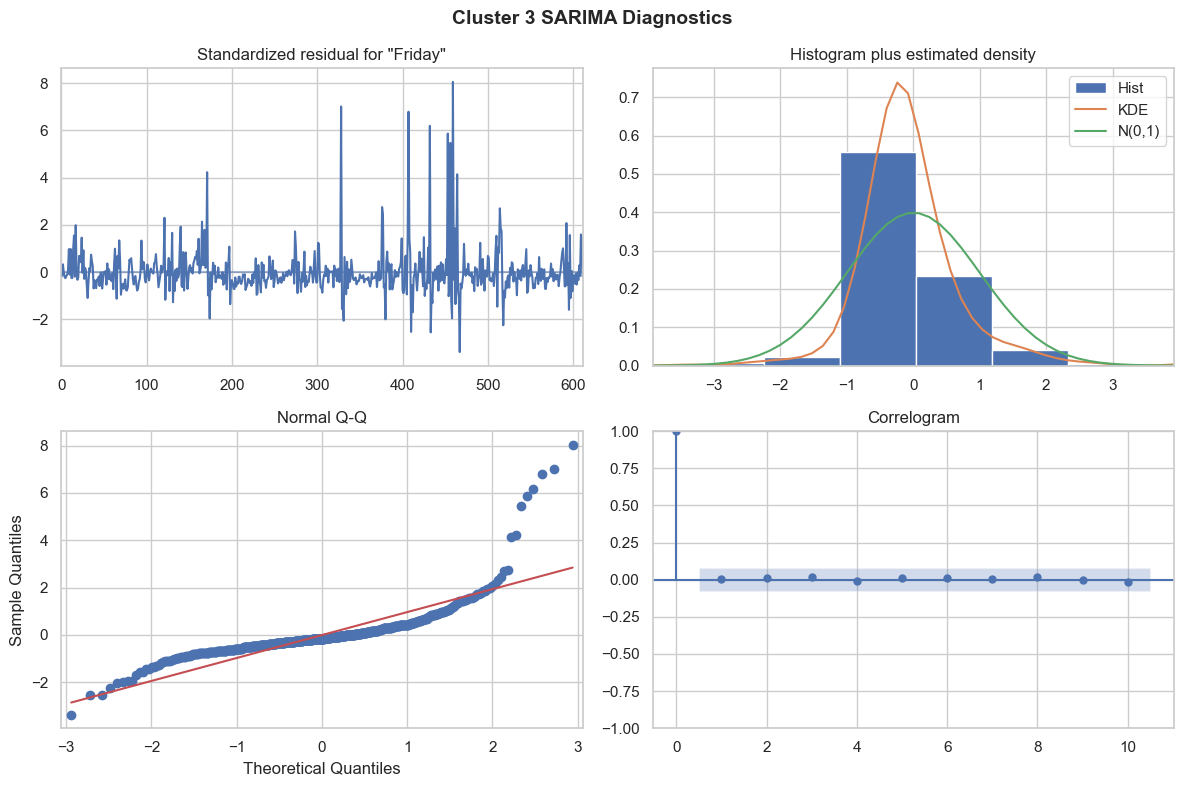

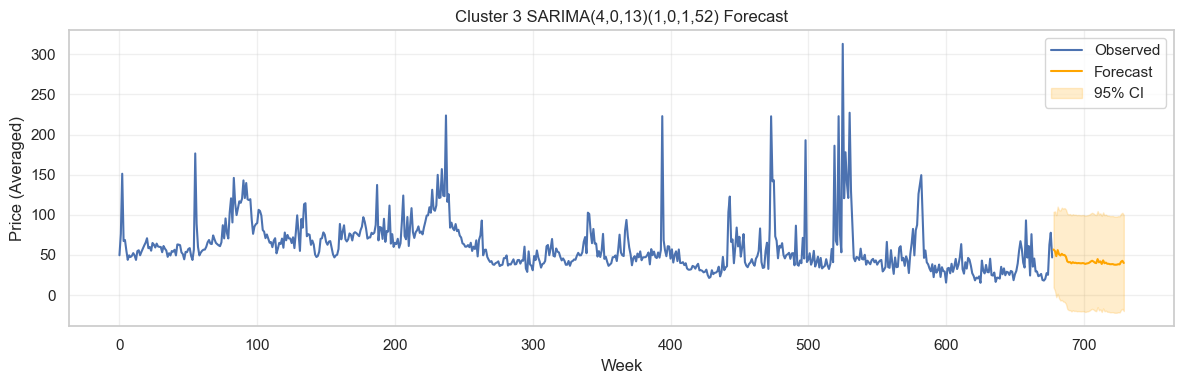


Cluster 4 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                     ('Wednesday', 14)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2777.092
Date:                               Tue, 03 Feb 2026   AIC                           5594.184
Time:                                       00:12:42   BIC                           5682.519
Sample:                                            0   HQIC                          5628.540
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5044      0.379      1.332      0

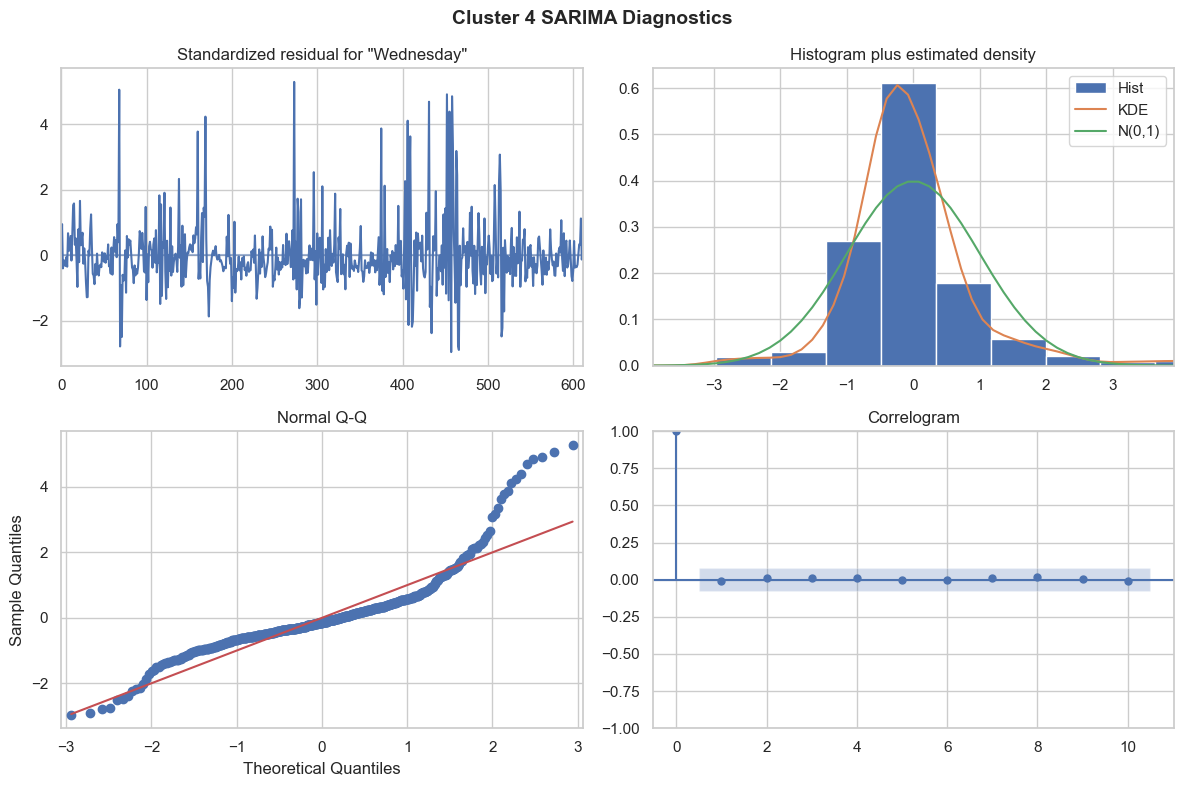

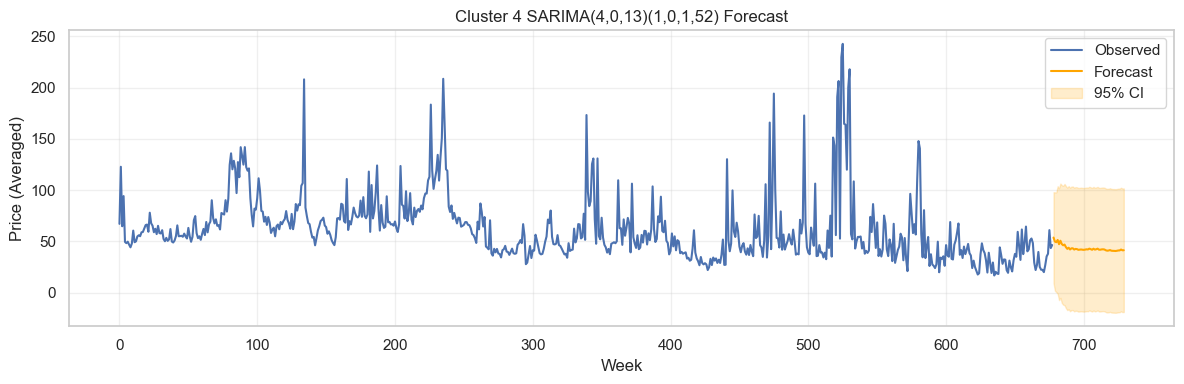


Cluster 5 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                        ('Sunday', 19)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2821.590
Date:                               Tue, 03 Feb 2026   AIC                           5683.180
Time:                                       00:14:27   BIC                           5771.514
Sample:                                            0   HQIC                          5717.536
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6978      0.629      1.110      0

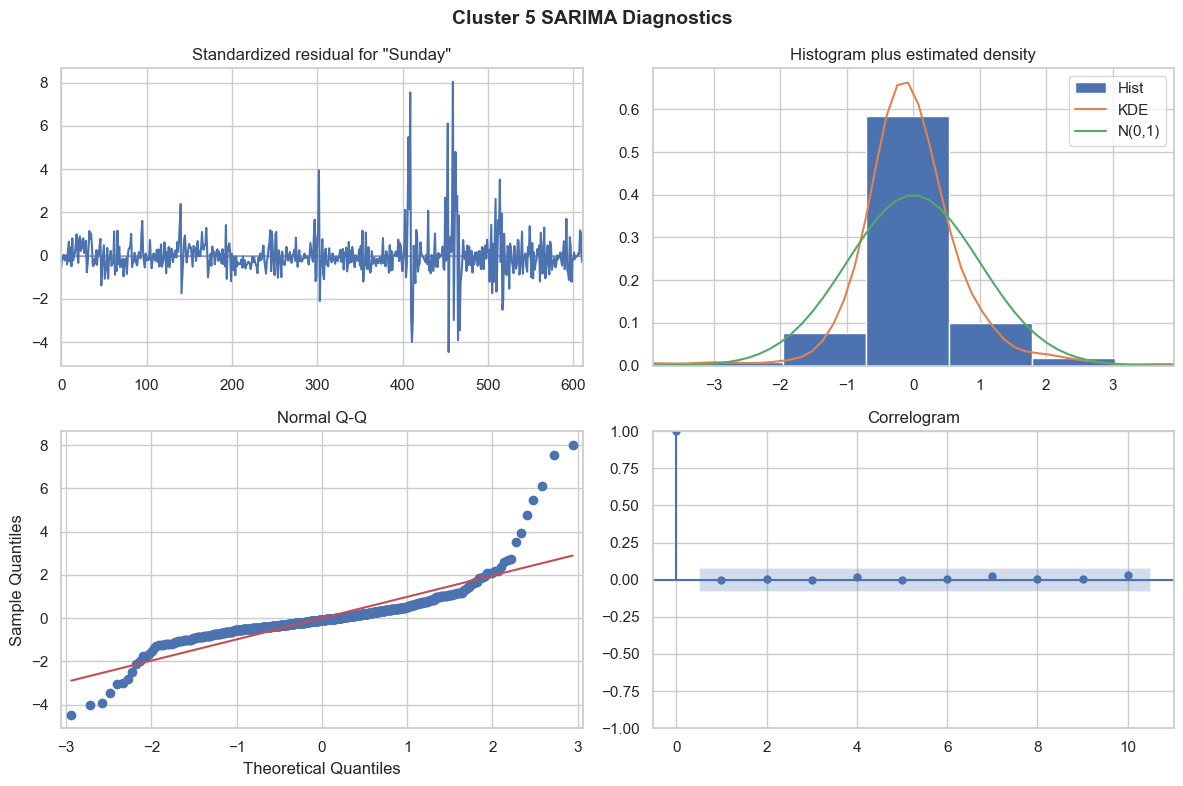

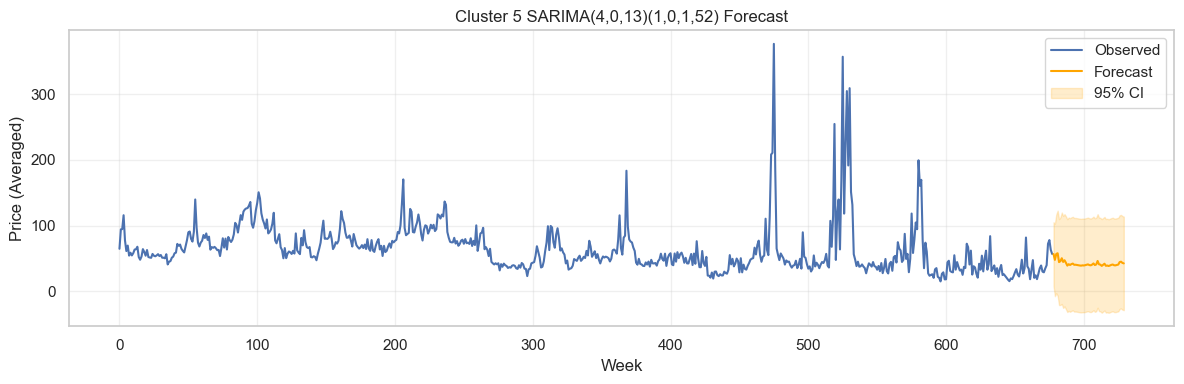


Cluster 6 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                        ('Sunday', 14)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2638.236
Date:                               Tue, 03 Feb 2026   AIC                           5316.472
Time:                                       01:49:15   BIC                           5404.807
Sample:                                            0   HQIC                          5350.829
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5564      0.719      0.774      0

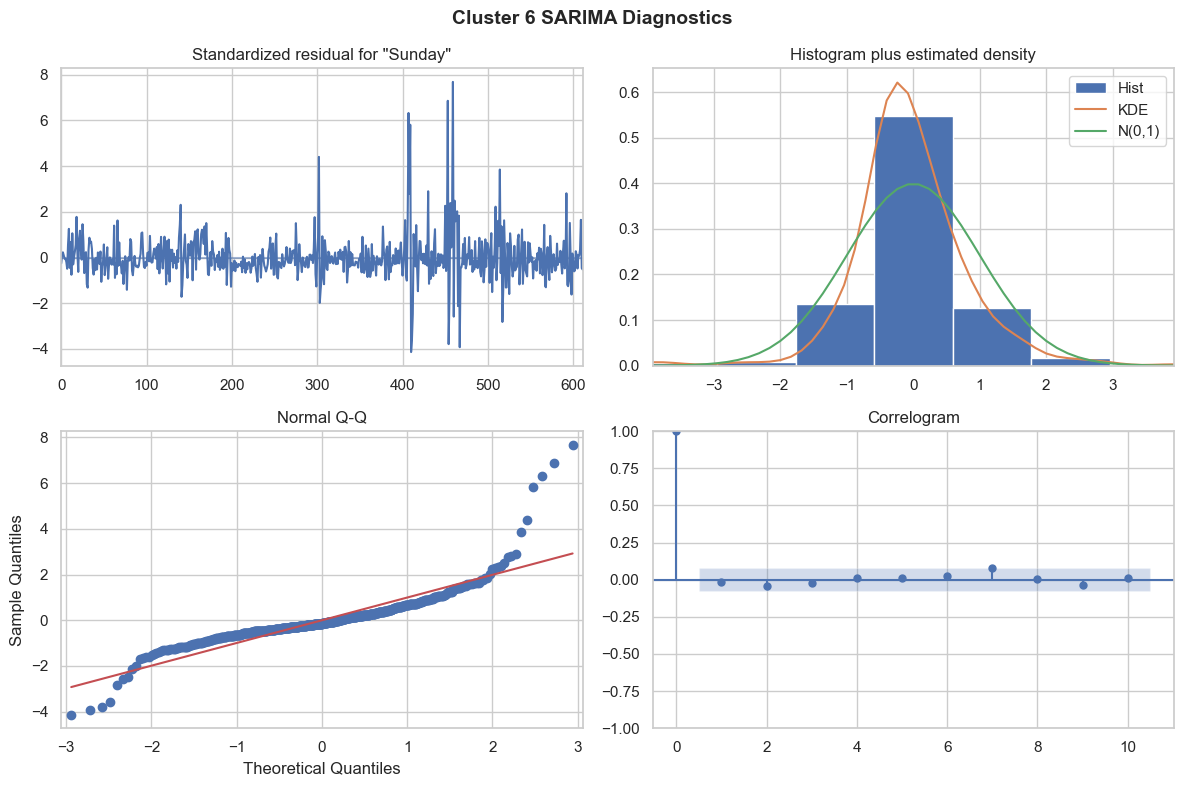

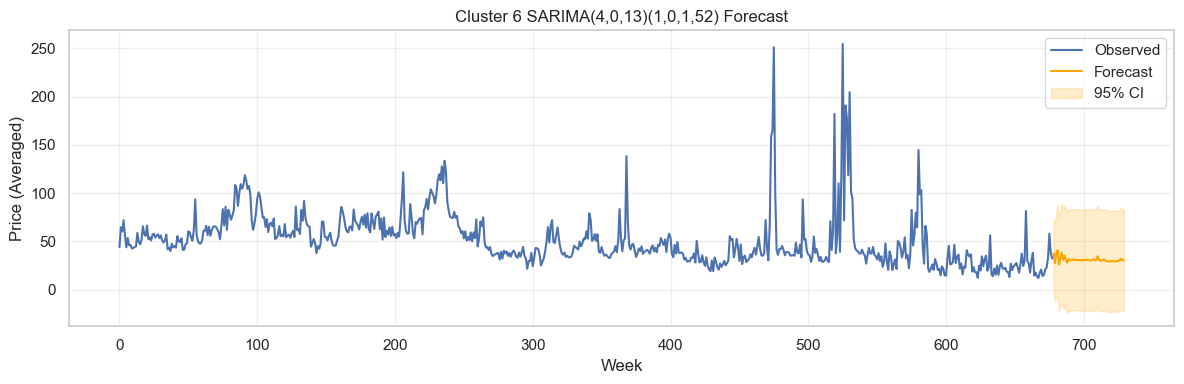


Cluster 7 SARIMA(4,0,13)(1,0,1,52) Fit
                                       SARIMAX Results                                       
Dep. Variable:                       ('Tuesday', 23)   No. Observations:                  678
Model:             SARIMAX(4, 0, 13)x(1, 0, [1], 52)   Log Likelihood               -2631.236
Date:                               Tue, 03 Feb 2026   AIC                           5302.472
Time:                                       01:57:09   BIC                           5390.807
Sample:                                            0   HQIC                          5336.829
                                               - 678                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6583      1.172      0.562      0

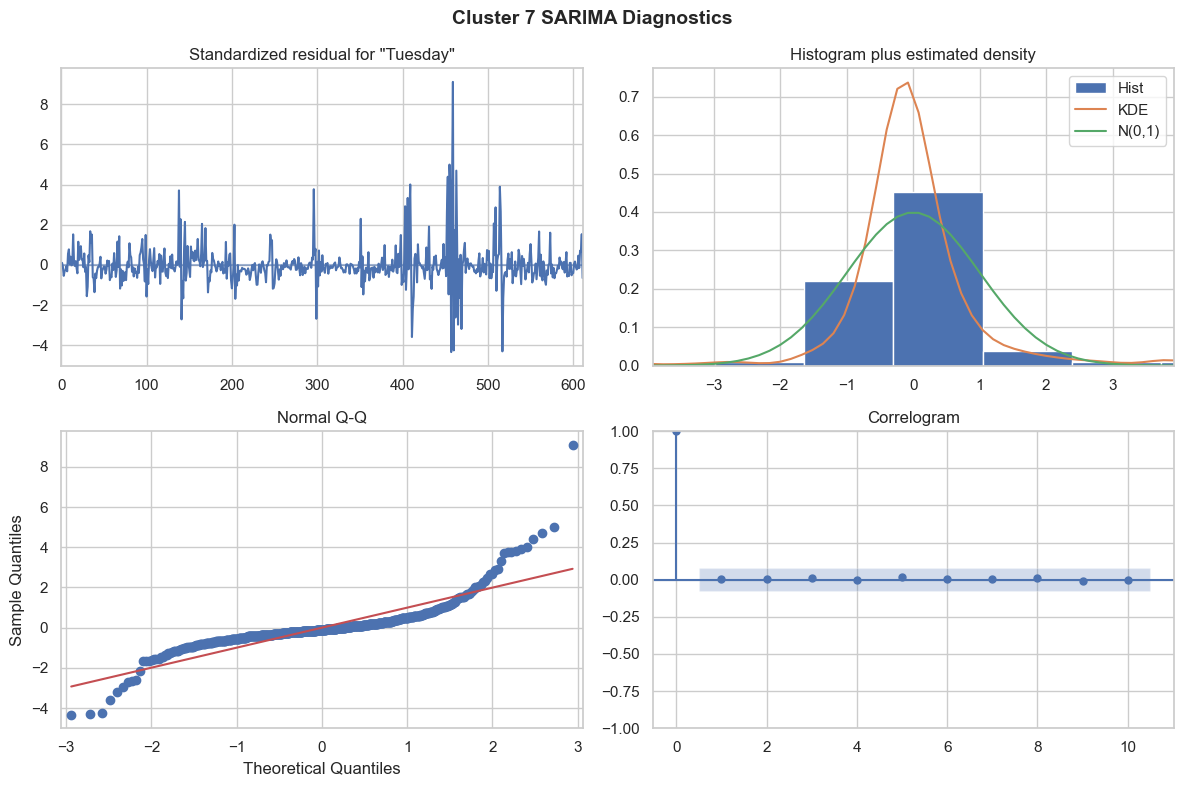

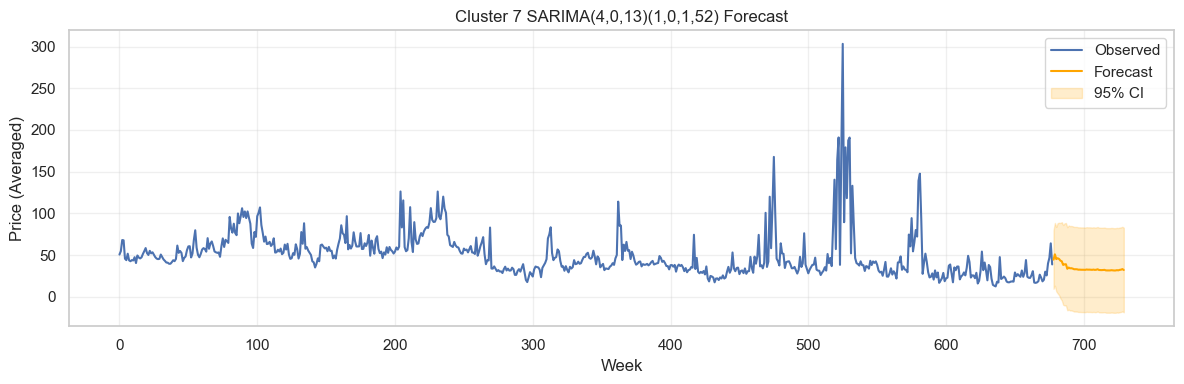

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_order = (4, 0, 13)
seasonal_order = (1, 0, 1, 52)

sarima_results = {}

for i, series in univariate_examples.items():
    print(f"\n{'='*60}\nCluster {i+1} SARIMA(4,0,13)(1,0,1,52) Fit\n{'='*60}")
    model = SARIMAX(series, order=sarima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    sarima_results[i] = result
    print(result.summary())
    
    # Plot diagnostics
    result.plot_diagnostics(figsize=(12, 8))
    plt.suptitle(f'Cluster {i+1} SARIMA Diagnostics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Forecast next 52 weeks
    forecast = result.get_forecast(steps=52)
    pred_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    plt.figure(figsize=(12, 4))
    plt.plot(series.index, series.values, label='Observed')
    plt.plot(range(series.index[-1]+1, series.index[-1]+53), pred_mean, color='orange', label='Forecast')
    plt.fill_between(range(series.index[-1]+1, series.index[-1]+53), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2, label='95% CI')
    plt.title(f'Cluster {i+1} SARIMA(4,0,13)(1,0,1,52) Forecast')
    plt.xlabel('Week')
    plt.ylabel('Price (Averaged)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## 6. 📈 Multivariate Modeling (VAR)

✅ Created 7 cluster representative series
   Shape: (678, 7)


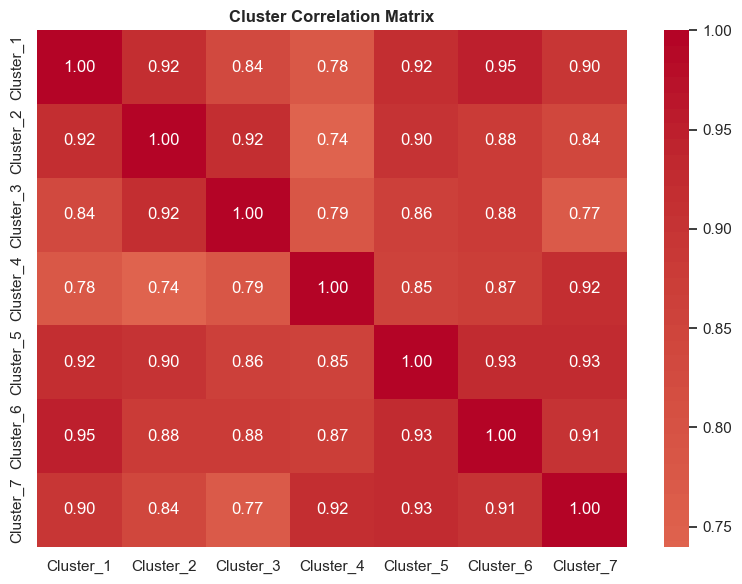

In [51]:
# ════════════════════════════════════════════════════════════════
# CREATE CLUSTER REPRESENTATIVES FOR VAR
# ════════════════════════════════════════════════════════════════

df_log_clean = df_log.copy()
cluster_series = pd.DataFrame()

for i in range(k_final):
    cluster_mask = cluster_labels == i
    cluster_data = df_log_clean.iloc[:, cluster_mask].mean(axis=1)
    cluster_series[f'Cluster_{i+1}'] = cluster_data

# Add jitter to prevent numerical issues
np.random.seed(42)
cluster_series = cluster_series + np.random.normal(0, 1e-6, cluster_series.shape)

print(f"✅ Created {k_final} cluster representative series")
print(f"   Shape: {cluster_series.shape}")

# Correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
corr = cluster_series.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Cluster Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

In [52]:
# ════════════════════════════════════════════════════════════════
# VAR MODEL FITTING ON LOG-PRICES (TREND-STATIONARY DATA)
# ════════════════════════════════════════════════════════════════

print("🔄 Fitting VAR model on log-prices...")
print("   Note: ADF test showed data is TREND-STATIONARY")
print("   → No differencing needed, use trend='ct' in VAR\n")

# Use log-prices directly (already trend-stationary)
var_data_log = cluster_series.dropna()

print(f"   Log-price series shape: {var_data_log.shape}")

# Fit VAR with constant + trend to handle the trend-stationarity
model = VAR(var_data_log)

try:
    # Select optimal lag order
    lag_selection = model.select_order(maxlags=12)
    print(f"\n   Lag Selection Criteria:")
    print(f"   AIC: {lag_selection.aic}, BIC: {lag_selection.bic}")
    
    # Use AIC-selected lag, minimum 2
    optimal_lag = max(lag_selection.aic, 2)
    
    # Fit with trend='ct' (constant + trend) for trend-stationary data
    results = model.fit(maxlags=min(optimal_lag, 10), trend='ct')
    
    print(f"\n✅ VAR model fitted on LOG-PRICES with trend='ct'")
    print(f"   Equations: {results.neqs}")
    print(f"   Lag order: {results.k_ar}")
    print(f"   Trend: constant + linear trend (handles trend-stationarity)")
    print(f"   AIC: {results.aic:.4f}")
    
except Exception as e:
    print(f"⚠️ Fitting with default settings due to: {e}")
    results = model.fit(maxlags=4, trend='ct')

🔄 Fitting VAR model on log-prices...
   Note: ADF test showed data is TREND-STATIONARY
   → No differencing needed, use trend='ct' in VAR

   Log-price series shape: (678, 7)

   Lag Selection Criteria:
   AIC: 10, BIC: 1

✅ VAR model fitted on LOG-PRICES with trend='ct'
   Equations: 7
   Lag order: 10
   Trend: constant + linear trend (handles trend-stationarity)
   AIC: -30.5086


✅ Forecasts converted to dollar prices
   Formula: Price = exp(log_price_forecast)



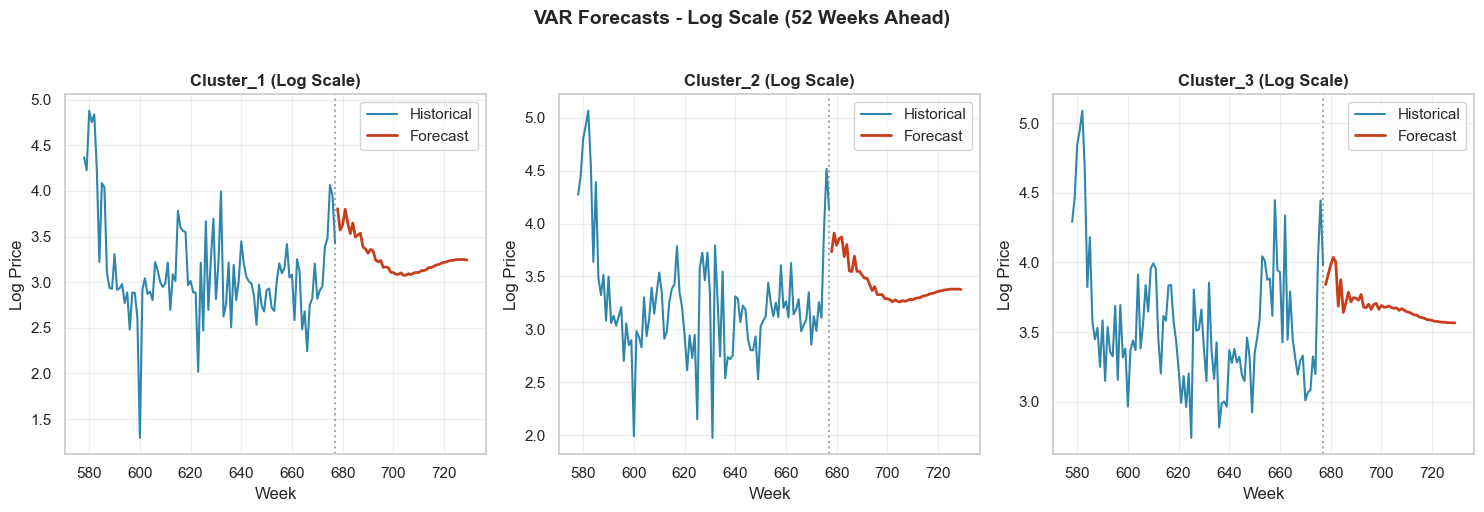

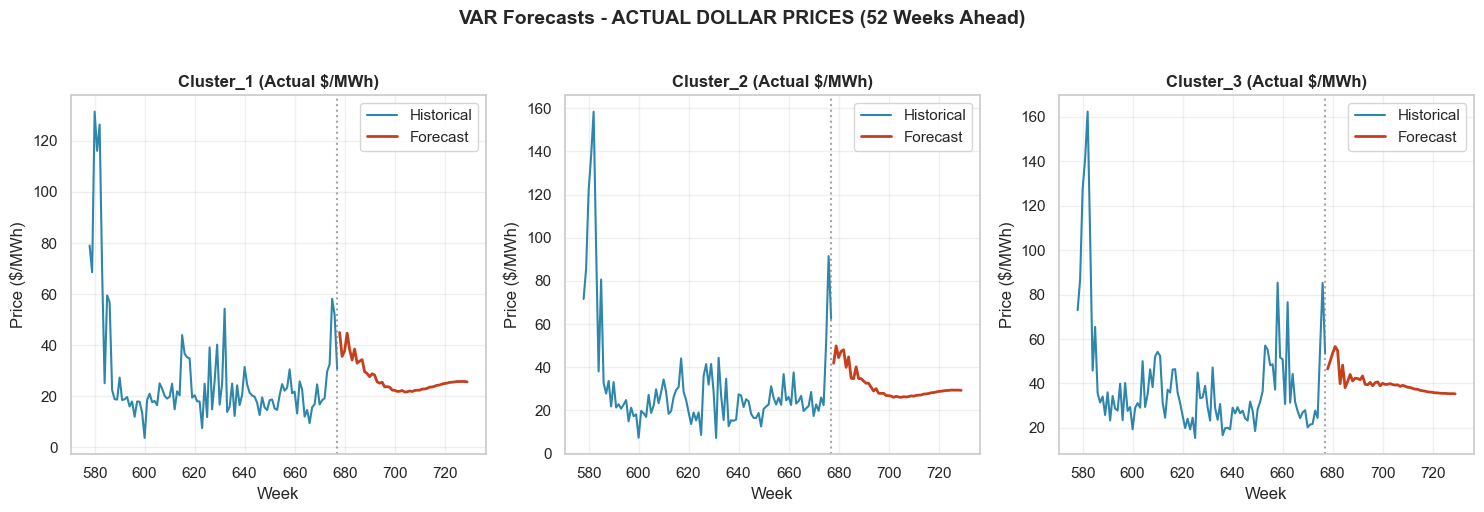


═══════════════════════════════════════════════════════════════════════════
📊 FORECAST SUMMARY (Actual Dollar Prices $/MWh)
═══════════════════════════════════════════════════════════════════════════
Cluster         Last Historical      Mean Forecast           Forecast Range
---------------------------------------------------------------------------
Cluster_1    $           30.73 $           26.89   [$21.64 - $44.93]
Cluster_2    $           62.48 $           31.25   [$26.01 - $49.88]
Cluster_3    $           53.57 $           40.06   [$35.34 - $56.63]
Cluster_4    $           46.81 $           42.24   [$37.20 - $60.80]
Cluster_5    $           64.97 $           44.47   [$36.97 - $73.11]
Cluster_6    $           42.23 $           35.64   [$31.98 - $53.45]
Cluster_7    $           38.41 $           33.28   [$27.45 - $58.17]

✅ Forecast completed

📝 Note: VAR point forecasts converge to the conditional mean.
   The volatility in historical data comes from unpredictable shocks.
   For un

In [56]:
# ════════════════════════════════════════════════════════════════
# VAR FORECASTING WITH EXP() TO DOLLAR PRICES
# ════════════════════════════════════════════════════════════════

forecast_steps = 52

try:
    lag_order = results.k_ar
    
    # Forecast log-prices directly
    forecast_input = var_data_log.values[-lag_order:]
    forecast_log = results.forecast(y=forecast_input, steps=forecast_steps)
    
    forecast_log_df = pd.DataFrame(
        forecast_log,
        columns=cluster_series.columns,
        index=range(len(var_data_log), len(var_data_log) + forecast_steps)
    )
    
    # ════════════════════════════════════════════════════════════════
    # CONVERT TO ACTUAL DOLLAR PRICES: exp(log_price) = price
    # ════════════════════════════════════════════════════════════════
    forecast_dollars_df = np.exp(forecast_log_df)
    historical_dollars = np.exp(var_data_log)
    
    print('✅ Forecasts converted to dollar prices')
    print('   Formula: Price = exp(log_price_forecast)\n')
    
    # ════════════════════════════════════════════════════════════════
    # PLOT 1: LOG SCALE FORECASTS
    # ════════════════════════════════════════════════════════════════
    n_show = min(3, k_final)
    fig, axes = plt.subplots(1, n_show, figsize=(15, 5))
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        col = f'Cluster_{i+1}'
        ax = axes[i]
        hist_log = var_data_log[col].iloc[-100:]
        ax.plot(hist_log.index, hist_log.values, color=COLORS['primary'], linewidth=1.5, label='Historical')
        ax.plot(forecast_log_df.index, forecast_log_df[col], color=COLORS['success'], 
                linewidth=2, label='Forecast')
        ax.axvline(len(var_data_log)-1, color='gray', linestyle=':', alpha=0.7)
        ax.set_xlabel('Week')
        ax.set_ylabel('Log Price')
        ax.set_title(f'{col} (Log Scale)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('VAR Forecasts - Log Scale (52 Weeks Ahead)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ════════════════════════════════════════════════════════════════
    # PLOT 2: ACTUAL DOLLAR PRICES (after exp transformation)
    # ════════════════════════════════════════════════════════════════
    fig, axes = plt.subplots(1, n_show, figsize=(15, 5))
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        col = f'Cluster_{i+1}'
        ax = axes[i]
        hist_dollars = historical_dollars[col].iloc[-100:]
        ax.plot(hist_dollars.index, hist_dollars.values, color=COLORS['primary'], linewidth=1.5, label='Historical')
        ax.plot(forecast_dollars_df.index, forecast_dollars_df[col], color=COLORS['success'], 
                linewidth=2, label='Forecast')
        ax.axvline(len(var_data_log)-1, color='gray', linestyle=':', alpha=0.7)
        ax.set_xlabel('Week')
        ax.set_ylabel('Price ($/MWh)')
        ax.set_title(f'{col} (Actual $/MWh)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('VAR Forecasts - ACTUAL DOLLAR PRICES (52 Weeks Ahead)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # ════════════════════════════════════════════════════════════════
    # SUMMARY TABLE IN DOLLARS
    # ════════════════════════════════════════════════════════════════
    print('\n' + '═'*75)
    print('📊 FORECAST SUMMARY (Actual Dollar Prices $/MWh)')
    print('═'*75)
    print(f"{'Cluster':<12} {'Last Historical':>18} {'Mean Forecast':>18} {'Forecast Range':>24}")
    print('-'*75)
    for i in range(k_final):
        col = f'Cluster_{i+1}'
        last_hist = historical_dollars[col].iloc[-1]
        mean_fc = forecast_dollars_df[col].mean()
        min_fc = forecast_dollars_df[col].min()
        max_fc = forecast_dollars_df[col].max()
        print(f'{col:<12} ${last_hist:>16.2f} ${mean_fc:>16.2f}   [${min_fc:.2f} - ${max_fc:.2f}]')
    
    print('\n✅ Forecast completed')
    print('\n📝 Note: VAR point forecasts converge to the conditional mean.')
    print('   The volatility in historical data comes from unpredictable shocks.')
    print('   For uncertainty bands, use forecast intervals (see next cell).')
    
except Exception as e:
    import traceback
    print(f'⚠️ Forecasting issue: {e}')
    traceback.print_exc()

🔄 Computing forecast intervals...



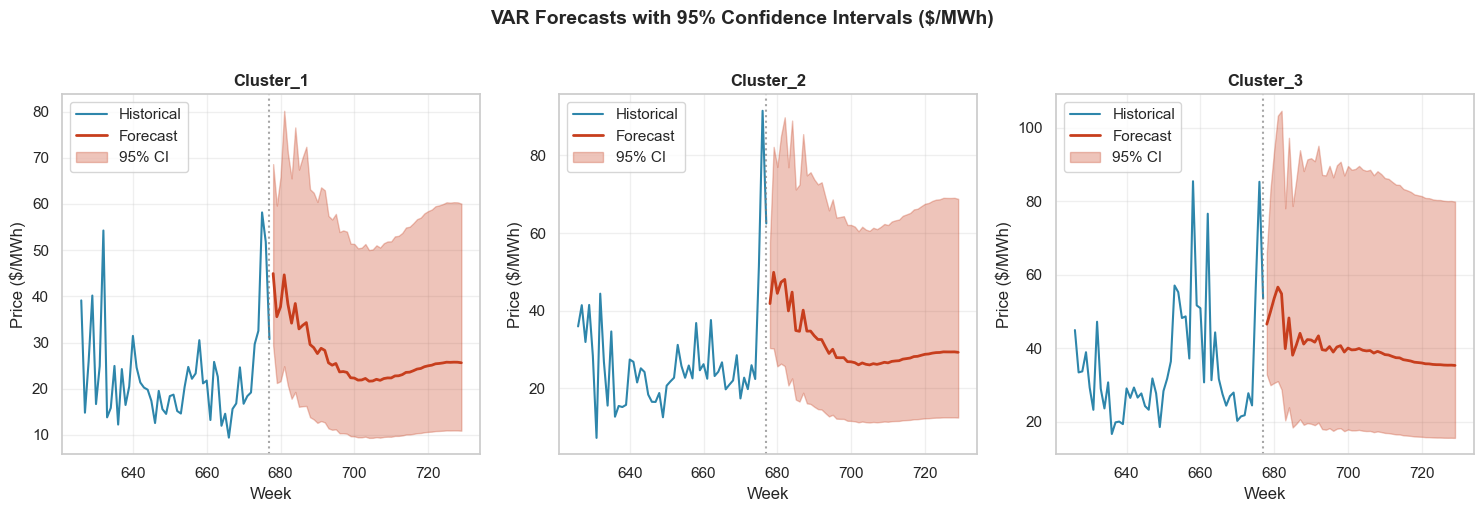

✅ Forecast intervals computed

📊 The shaded region shows 95% confidence interval.
   Wider bands = more uncertainty at longer horizons.


In [54]:
# ════════════════════════════════════════════════════════════════
# VAR FORECAST WITH CONFIDENCE INTERVALS (95%)
# ════════════════════════════════════════════════════════════════

print("🔄 Computing forecast intervals...\n")

try:
    # Get forecast with confidence intervals
    forecast_result = results.forecast_interval(var_data_log.values[-lag_order:], 
                                                 steps=forecast_steps, alpha=0.05)
    
    forecast_mean = forecast_result[0]  # Point forecast
    forecast_lower = forecast_result[1]  # Lower 95% CI
    forecast_upper = forecast_result[2]  # Upper 95% CI
    
    # Convert to DataFrames
    fc_idx = range(len(var_data_log), len(var_data_log) + forecast_steps)
    
    fc_mean_df = pd.DataFrame(forecast_mean, columns=cluster_series.columns, index=fc_idx)
    fc_lower_df = pd.DataFrame(forecast_lower, columns=cluster_series.columns, index=fc_idx)
    fc_upper_df = pd.DataFrame(forecast_upper, columns=cluster_series.columns, index=fc_idx)
    
    # Convert to DOLLARS
    fc_mean_dollars = np.exp(fc_mean_df)
    fc_lower_dollars = np.exp(fc_lower_df)
    fc_upper_dollars = np.exp(fc_upper_df)
    
    # ════════════════════════════════════════════════════════════════
    # PLOT: FORECASTS WITH 95% CONFIDENCE INTERVALS IN DOLLARS
    # ════════════════════════════════════════════════════════════════
    n_show = min(3, k_final)
    fig, axes = plt.subplots(1, n_show, figsize=(15, 5))
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        col = f'Cluster_{i+1}'
        ax = axes[i]
        
        # Historical
        hist_dollars = historical_dollars[col].iloc[-52:]
        ax.plot(hist_dollars.index, hist_dollars.values, 
                color=COLORS['primary'], linewidth=1.5, label='Historical')
        
        # Forecast mean
        ax.plot(fc_mean_dollars.index, fc_mean_dollars[col], 
                color=COLORS['success'], linewidth=2, label='Forecast')
        
        # 95% Confidence Interval
        ax.fill_between(fc_mean_dollars.index, 
                        fc_lower_dollars[col], 
                        fc_upper_dollars[col],
                        color=COLORS['success'], alpha=0.3, label='95% CI')
        
        ax.axvline(len(var_data_log)-1, color='gray', linestyle=':', alpha=0.7)
        ax.set_xlabel('Week')
        ax.set_ylabel('Price ($/MWh)')
        ax.set_title(f'{col}', fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('VAR Forecasts with 95% Confidence Intervals ($/MWh)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print('✅ Forecast intervals computed')
    print('\n📊 The shaded region shows 95% confidence interval.')
    print('   Wider bands = more uncertainty at longer horizons.')
    
except Exception as e:
    print(f'⚠️ Could not compute forecast intervals: {e}')
    print('   This may occur if the VAR model has numerical issues.')

---
## 8. 📋 Conclusions

### Summary of Key Findings

---

## References

1. Peña, D. and Tsay, R.S. (2021). *Statistical Learning for Big Dependent Data*. Wiley.

2. Peña, D., Tsay, R.S., and Zamar, R. (2019). Empirical Dynamic Quantiles for Visualization of High-Dimensional Time Series. *Technometrics*.

3. Alonso, A.M. and Peña, D. (2019). Clustering time series by linear dependency. *Statistics and Computing*.

---

**End of Notebook**